In [2]:
# codes Github to make Fig. of https://arxiv.org/abs/2506.16449
# I. Achitouv summer 2025

In [1]:
import math
import random
import re
import ast
import json
from pathlib import Path
from collections import defaultdict, Counter
from itertools import product, permutations
from random import sample
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle, ConnectionPatch
import matplotlib.patches as mpatches

import networkx as nx
import graphviz
import pydot  # https://github.com/pydot/pydot
from bs4 import BeautifulSoup

from scipy import stats
from scipy.linalg import eigh
from scipy.optimize import minimize
from scipy.spatial import KDTree
from scipy.spatial.distance import pdist, squareform
from scipy.stats import (
    zscore,
    poisson,
    kurtosis,
    skew,
)
from numpy import linalg as LA

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score

from yahoo_fin.stock_info import get_data
import yfinance as yf

from fa2_modified import ForceAtlas2
from double_loop import filter_edges

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

plt.style.use('fivethirtyeight')
%matplotlib inline

In [40]:
def rolling_mean_dataframe(df, window=2, min_periods=1):
    """
    Calculate the rolling mean for each column in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    window (int): The size of the moving window. Default is 2.
    min_periods (int): Minimum number of observations in window required to have a value. Default is 1.

    Returns:
    pd.DataFrame: A new DataFrame with the rolling means.
    """
    return df.rolling(window=window, min_periods=min_periods).mean()


# Compute properties for box across candidate (removing candidate self-influence):
def zero_same_candidate(matrix):
    for row in matrix.index:
        for col in matrix.columns:
                # Extract candidate names (substring before the first '-')
            row_candidate = row.split('-')[0]
            col_candidate = col.split('-')[0]
                # Set correlation to zero if the source and target are the same candidate
            if row_candidate == col_candidate:
                matrix.loc[row, col] = 0
    return matrix
        
def compute_dynamics_changes(df, window_size,opt):
    """
    Computes the rolling eigenvalue distribution of the correlation matrix for each period and calculates causal influence 
    if the variance of eigenvalues exceeds the mean + std over the entire time range.

    Parameters:
    - df: DataFrame with time series data
    - window_size: Size of the rolling window for computing eigenvalues and correlations (14 in this case)
    
    Returns:
    - time_interest: List of times indicating collective events/change in dynamics from max eigenvalue variation (Delta_max_eig)
      and quantile variation (Delta_quant).
    """
    # Base quantile for the entire dataset
    quant90base = np.quantile(df.values.flatten(), 0.85)
    time_interest = []
    
    # Lists to store the metrics for plotting
    delta_max_eig_vals = []
    eigenvalue_std_change_vals = []
    delta_quant_vals = []
    significant_times = []  # List to store the window start times where significant changes occur
    time_split = []  # List to store the start times of the rolling windows
    
    # Compute eigenvalue metrics for the full correlation matrix
    full_corr_matrix = df.corr()
    eigenvalues_full, _ = eigh(full_corr_matrix)
    eigenvalue_max = np.max(eigenvalues_full)
    eigenvalue_std = np.std(eigenvalues_full)

    # dictionary of key nodes per sliding time
    dic_keynodes = {
    'eig': [],
    'btw': [],
    'clos': []
    }



    # for the plots of graph at each time: 
    starts = range(0, len(df) - window_size + 1, window_size)
    n_subplots = len(starts)
    # Define subplot grid
    n_cols = 4  # You can change this to control layout
    n_rows = math.ceil(n_subplots / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()
    counter = 0
        
    # Rolling window analysis
    for start in range(0, len(df) - window_size + 1, window_size):
        # Extract rolling window data
        window_data = df.iloc[start:start + window_size]
        
        # Handle potential NaN values in window data
        if window_data.isnull().values.any():
            window_data = window_data.dropna(axis=1, how='any')
        
        # Compute correlation matrix
        if not window_data.empty:
            corr_matrix = zero_same_candidate(window_data.corr())
        else:
            continue  # Skip windows with insufficient data
        
        # Compute eigenvalues
        eigenvalues, _ = eigh(corr_matrix)
        
        # Compute metrics for this window
        quant90 = np.quantile(window_data.values.flatten(), 0.85)
        Delta_max_eig = np.max(eigenvalues) / eigenvalue_max - 1
        Delta_quant = quant90 / quant90base - 1
        Eigenvalue_std_change = np.std(eigenvalues) / eigenvalue_std - 1
        
        # Append the metrics to the lists for plotting
        delta_max_eig_vals.append(Delta_max_eig)
        eigenvalue_std_change_vals.append(Eigenvalue_std_change)
        delta_quant_vals.append(Delta_quant)
        
        # Keep track of the window start time
        time_split.append(start)

       
        # option 1 no agregation, option 2 agreg per candidates option 3 agreg per topic
        if opt==1:
            corr_matrix_op=corr_matrix
        elif opt==2:
            # Step 1: Extract candidate names from row/column labels
            candidate_names = corr_matrix.columns.str.extract(r'(^[^-]+)')[0]

            # Step 2: Create MultiIndex for new DataFrame (leave `dftest` unchanged)
            columns_multi = pd.MultiIndex.from_arrays([candidate_names, corr_matrix.columns])
            index_multi = pd.MultiIndex.from_arrays([candidate_names, corr_matrix.index])
            
            # Step 3: Create a copy of dftest with new multi-indexes
            df_multi = pd.DataFrame(corr_matrix.values, index=index_multi, columns=columns_multi)
            
            # Step 4: Group and average by candidate
            corr_matrix_op = df_multi.groupby(level=0).mean().groupby(level=0, axis=1).mean()
        elif opt==3:
            # Step 1: Extract candidate names from row/column labels
            candidate_names = corr_matrix.columns.str.extract(r'-([^-\n\r]+)$')[0]

            # Step 2: Create MultiIndex for new DataFrame (leave `dftest` unchanged)
            columns_multi = pd.MultiIndex.from_arrays([candidate_names, corr_matrix.columns])
            index_multi = pd.MultiIndex.from_arrays([candidate_names, corr_matrix.index])
            
            # Step 3: Create a copy of dftest with new multi-indexes
            df_multi = pd.DataFrame(corr_matrix.values, index=index_multi, columns=columns_multi)
            
            # Step 4: Group and average by candidate
            corr_matrix_op = df_multi.groupby(level=0).mean().groupby(level=0, axis=1).mean()
           

        
        # compute graph and find candidate & topic nodes more central:
        mask_value =np.quantile(np.abs(corr_matrix_op.values.flatten()), 0.85)
        masked_matrix = corr_matrix_op[np.abs(corr_matrix_op) >= mask_value]
        masked_matrix = masked_matrix.fillna(0)
        masked_matrix = masked_matrix.replace(1, 0)  # Remove self-loops or self-correlation 
        masked_matrix=np.abs(masked_matrix)
        graph = nx.from_pandas_adjacency(masked_matrix, create_using=nx.Graph)
        graph2 = nx.from_pandas_adjacency(masked_matrix, create_using=nx.Graph)
        graph2.remove_edges_from(nx.selfloop_edges(graph2))
        graph2.remove_nodes_from(list(nx.isolates(graph2)))
        pos = nx.kamada_kawai_layout(graph, weight='weight')
        # Extract edge weights and scale them for widths
        weights = nx.get_edge_attributes(graph2, 'weight')
        max_weight = max(weights.values()) if weights else 1
        
        # Scale weights to a reasonable width range, e.g., 0.5 to 5
        edge_widths = [0.5 + 10 * (w / max_weight)**0.2 for w in weights.values()]

        ax = axes[counter]
        ax.set_title(f"Step {start}")
        nx.draw(graph2, pos, with_labels=True, node_size=300, node_color='skyblue',font_size=20,
                edge_color='gray', width=edge_widths, ax=ax)
        counter += 1
        
        #plt.figure(figsize=(8, 6))
        #nx.draw(graph2, pos, with_labels=True, node_size=300, node_color='skyblue',
        #plt.title(f"Graph at step {start}")
        #        edge_color='gray', width=edge_widths)
        #plt.savefig(f"fig/graph_{start}_{opt}.png")
        #plt.close()
        
        # Compute centrality measures
        betweenness_centrality = nx.betweenness_centrality(graph, weight='weight')
        closeness_centrality = nx.closeness_centrality(graph, distance='weight')
        eigenvector_centrality =dict(graph.degree(weight='weight'))
        
        #nx.eigenvector_centrality(graph) #dict(graph.degree(weight='weight')) #nx.eigenvector_centrality(graph)
        
        # Identify the top 3 nodes for each measure 
        top_betweenness = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:1]
        top_degree = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:1]
        top_closeness = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:1]
        
        dic_keynodes['eig'].append(top_degree)
        dic_keynodes['btw'].append(top_betweenness)        
        dic_keynodes['clos'].append(top_closeness)
    
    # Hide any unused subplots
    for j in range(counter, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig("fig/all_steps_option"+str(opt)+".png")
    plt.close()

    # Now loop over all time_split values to define significant changes
    for isplit in range(len(time_split)):    
        # Check if Eigenvalue_std_change for this time split is significantly higher than the mean
        #print(delta_max_eig_vals[isplit] / np.mean(delta_max_eig_vals)-1)
        significant_change = (delta_max_eig_vals[isplit] > 1)
        if significant_change:
            time_interest.append(time_split[isplit])  # Store the time when the condition is satisfied
            significant_times.append(time_split[isplit])  # Store the significant times
            
            
            
    # Loop over periods between significant changes
    for i in range(1, len(significant_times)):
        # Get the period between two significant changes
        start_period = significant_times[i-1]
        end_period = significant_times[i]

        # Compute correlation matrix for this period (from start_period to end_period)
        period_data = df.iloc[start_period:end_period]
        
        if not period_data.empty:
            period_corr_matrix = period_data.corr()

            # Mask the correlation matrix based on the 97th percentile
            mask_value = np.quantile(np.abs(period_corr_matrix.values.flatten()), 0.9)
            masked_matrix = period_corr_matrix[np.abs(period_corr_matrix) >= mask_value]
            masked_matrix = masked_matrix.fillna(0)
            masked_matrix = masked_matrix.replace(1, 0)  # Remove self-loops or self-correlation if desired
            masked_matrix=np.abs(masked_matrix)
            # Create a time label based on the period
            timedate = f"period_{dic_date[start_period]}_{dic_date[end_period]}"

            # Generate and save the graph for this period
            #make_graph_undir(masked_matrix, 0.4, timedate)

            # find candidate & topic nodes more central:
            graph = nx.from_pandas_adjacency(masked_matrix, create_using=nx.Graph)
            # Compute centrality measures
            betweenness_centrality = nx.betweenness_centrality(graph, weight='weight')
            closeness_centrality = nx.closeness_centrality(graph, distance='weight')
            eigenvector_centrality =dict(graph.degree(weight='weight'))
            #nx.eigenvector_centrality(graph) #dict(graph.degree(weight='weight')) #nx.eigenvector_centrality(graph)
            
                # Identify the top 3 nodes for each measure
            top_betweenness = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:1]
            top_degree = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:1]
            top_closeness = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:1]
            
            #dic_keynodes['eig'].append(top_degree)
            #dic_keynodes['btw'].append(top_betweenness)        
            #dic_keynodes['clos'].append(top_closeness)
        
   
    return time_interest,delta_max_eig_vals,time_split,dic_keynodes


def computeCCM_matrix(dftemp,max_lag):
    # dftemp time series for different columns 
    # return CCM matrix at best lag 


    Emin=2
    k_Emin=Emin+1
    columns = dftemp.columns
    n_vars = len(dftemp.columns)
    te_matrix = pd.DataFrame(np.zeros((n_vars, n_vars)), index=columns, columns=columns)
    lag_matrix = pd.DataFrame(np.zeros((n_vars, n_vars)), index=columns, columns=columns)
    for source in columns:
        series1=np.array(dftemp[source].tolist())
        for target in columns:
            if source !=target:
                series2=np.array(dftemp[target].tolist())
                corr_CCM = functionccm(series1, series2,max_lag, E=Emin, k=k_Emin)
                val=max(corr_CCM.values()) # that's when there is more than one lag 
                key_with_max_value = max(corr_CCM, key=corr_CCM.get)
                te_matrix.loc[source,target]=round(np.max(val),3)
                lag_matrix.loc[source,target]=key_with_max_value
    return te_matrix,lag_matrix

def functionccm(X, Y,max_lag, E=2, k=3):
    """
    Compute Convergent Cross Mapping (CCM) to determine if X causes Y.
    
    Parameters:
    - X: Time series X (the potential cause).
    - Y: Time series Y (the potential effect).
    - E: Embedding dimension (default is 2).
    - tau: Time delay (default is 1).
    - k: Number of nearest neighbors for reconstruction (default is 3). Usually E+1
    
    Returns:
    - Correlation coefficient between original Y and reconstructed Y (measures causality).
    """
    # Step 1: Embed both time series
    corr={}
    for tau in range(1,max_lag):
        X_embed = embed_series(X, E, tau)
        Y_embed = embed_series(Y, E, tau)
        
        # Step 2: Find nearest neighbors in X's embedded space
        X_neighbors = nearest_neighbors(X_embed, k)
        
        # Step 3: Reconstruct Y using the X neighbors
        Y_reconstructed = cross_map(X_embed, Y, X_neighbors)
        
        # Step 4: Compute correlation between original Y and reconstructed Y
        correlation = np.corrcoef(Y_reconstructed, Y[:len(Y_reconstructed)])[0, 1]
        corr[tau]=correlation
    return corr
def embed_series(series, E, tau):
    """
    Embed the time series using delay embedding.
    
    Parameters:
    - series: The original time series.
    - E: Embedding dimension.
    - tau: Time delay.
    
    Returns:
    - The embedded time series as a matrix.
    """
    N = len(series)
    embedded = np.array([series[i:i + E * tau:tau] for i in range(N - (E - 1) * tau)])
    return embedded
def nearest_neighbors(embed, k):
    """
    Find the k-nearest neighbors in the embedded space using KDTree.
    
    Parameters:
    - embed: Embedded time series.
    - k: Number of nearest neighbors to find.
    
    Returns:
    - The indices of the nearest neighbors.
    """
    tree = KDTree(embed)
    distances, indices = tree.query(embed, k+1)  # +1 to exclude self
    return indices[:, 1:]  # Remove self as the nearest neighbor
def cross_map(X_embed, Y, neighbors):
    """
    Perform cross mapping by reconstructing the Y series using neighbors from X.
    
    Parameters:
    - X_embed: The embedded X time series.
    - Y: The target Y series to reconstruct.
    - neighbors: Nearest neighbors for cross mapping.
    
    Returns:
    - The reconstructed Y series.
    """
    reconstructed_Y = np.zeros(len(neighbors))
    epsilon=1e-10
    for i, nbr_indices in enumerate(neighbors):
        # Weight the neighbors by their inverse distance
        weights = 1 / np.maximum(np.linalg.norm(X_embed[i] - X_embed[nbr_indices], axis=1), epsilon)
        weights /= weights.sum()
        
        # Reconstruct Y by weighted average of Y values at neighbor indices
        reconstructed_Y[i] = np.dot(weights, Y[nbr_indices])
    
    return reconstructed_Y


def aggregate_percand(matrix):
    # Extract candidate names from row and column labels
    row_candidates = matrix.index.str.split('-').str[0].unique()
    col_candidates = matrix.columns.str.split('-').str[0].unique()
    
    # Ensure all candidates are included in both rows and columns
    all_candidates = sorted(set(row_candidates).union(set(col_candidates)))
    
    # Create a new DataFrame to store aggregated values with all candidates
    candidate_matrix = pd.DataFrame(index=all_candidates, columns=all_candidates, dtype=float).fillna(0)
    
    # Loop through each pair of candidates (source, target)
    for src in all_candidates:
        for tgt in all_candidates:
            # Filter submatrix for the specific pair of candidates
            submatrix = matrix.loc[
                matrix.index.str.startswith(src + '-'), 
                matrix.columns.str.startswith(tgt + '-')
            ]
            # Compute the average transfer entropy and assign it
            if not submatrix.empty:  # Avoid empty selections
                candidate_matrix.loc[src, tgt] = submatrix.values.mean()

    # Set diagonal values to zero
    for candidate in all_candidates:
        candidate_matrix.loc[candidate, candidate] = 0
    
    return candidate_matrix


from fa2_modified import ForceAtlas2
def make_graph_undir(filtered_CorrM, kspatial, timedate,dic_col):
    """
    Creates and plots an undirected graph and includes a panel for the top nodes based on centrality measures.

    Parameters:
    - filtered_CorrM: The correlation matrix (pandas DataFrame) used to create the graph
    - kspatial: A parameter that influences the spring layout's spacing (controls layout aesthetics)
    - timedate: A string representing the timestamp to be added to the saved file name.
    """
    import matplotlib.gridspec as gridspec
    from networkx.algorithms.community import k_clique_communities
   

    # Create an undirected graph from the correlation matrix
    graph = nx.from_pandas_adjacency(filtered_CorrM, create_using=nx.Graph)
    #graph.remove_nodes_from(list(nx.isolates(graph)))  # Remove isolated nodes
    Louvain=1
    if Louvain==1:
        # Apply Louvain community detection on the graph (weighted edges)
        partition = list(nx.community.louvain_communities(graph, weight='weight', resolution=0.1))
        # Assuming 'graph' is your NetworkX graph
        # Print the Louvain communities
        print("Louvain communities:")
        for community_id, community in enumerate(partition):
           # if len(community)>0:
            print(f"Community {community_id} has {len(community)} nodes: {sorted(list(community))}")

    
    # Compute centrality measures on graph 2 which remove self loop!
    corr2matrix=zero_same_candidate(filtered_CorrM)
    graph2 = nx.from_pandas_adjacency(corr2matrix, create_using=nx.Graph)
    betweenness_centrality = nx.betweenness_centrality(graph2, weight='weight')
    degree_centrality =dict(graph2.degree(weight='weight')) #nx.eigenvector_centrality(graph) #nx.degree_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph2, distance='weight')

    # Identify the top 3 nodes for each measure
    top_betweenness = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:1]
    top_degree = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:1]
    top_closeness = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:1]

    plotoption1=0
    if plotoption1==1: 
        # Union of the three sets to get the unique top nodes
        top_nodes = list(set(top_betweenness + top_degree + top_closeness))
    
        # Prepare values for plotting
        node_betweenness_values = [betweenness_centrality[node] for node in top_nodes]
        node_degree_values = [degree_centrality[node] for node in top_nodes]
        node_closeness_values = [closeness_centrality[node] for node in top_nodes]

    else: 
        # Get the node with the highest centrality for each measure
        top_degree_node = max(degree_centrality, key=degree_centrality.get)
        top_closeness_node = max(closeness_centrality, key=closeness_centrality.get)
        top_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
    
        top_nodes = [top_betweenness_node, top_degree_node, top_closeness_node]
        centrality_types = ['Betweenness', 'Degree', 'Closeness']
        centrality_values = [
            betweenness_centrality[top_betweenness_node],
            degree_centrality[top_degree_node],
            closeness_centrality[top_closeness_node]
        ]


    
    # Node colors based on candidate
    node_colors = [dic_col.get(node.split('-')[0], 'gray') for node in top_nodes]


    # Remove isolated nodes (those without any edges)
    isolated_nodes = list(nx.isolates(graph))
    graph.remove_nodes_from(isolated_nodes)
    
    # Extract the topic part for labeling (assuming nodes are formatted as 'candidate-topic')
    node_labels = {node: node.split('-')[1] for node in graph.nodes()}
    
    
    # Determine the 85th quantile threshold for node centrality
    
    threshold = np.quantile(list(betweenness_centrality.values()), 0.85)
    threshold2 = np.quantile(list(degree_centrality.values()), 0.85)
    maxdeg=max(list(degree_centrality.values()))
    maxbtw=max(list(betweenness_centrality.values()))
    # Prepare node colors and square/round shapes
    node_colors = []
    node_shapes = []
    node_alphas = []
    node_sizes=[]
    for node in graph.nodes():
        candidate = node.split('-')[0]
        color = dic_col.get(candidate, 'gray')
        
        # If the node's centrality is above the threshold, make it square
        #shape = 's' if degree_centrality[node] >= threshold else 'o'  # 's' for square, 'o' for circle
        if betweenness_centrality[node]>=threshold and degree_centrality[node]>=threshold2:
            shape='*'
            alpha=1
            node_sizes.append(700+50*np.exp((degree_centrality[node]/maxdeg+betweenness_centrality[node]/maxbtw)*2.5))
        elif betweenness_centrality[node]>=threshold:
            shape='s'
            alpha=1
            node_sizes.append(700+50*np.exp((betweenness_centrality[node]/maxbtw)))
            
        elif degree_centrality[node]>=threshold2:
            shape='D'
            alpha=1
            node_sizes.append(700+50*np.exp((degree_centrality[node]/maxdeg)))
           
        else:
            shape='o'
            alpha=0.5 #0.2
            node_sizes.append(700)
        node_colors.append(color)
        node_shapes.append(shape)
        node_alphas.append(alpha)
    

    
    # Extract date from the timestamp
    if timedate[:len('period_')]=='period_':
        ttstr=timedate[len('period_'):]
    else:
        ttstr=timedate
    start_datetime, end_datetime = ttstr.split('_')

    # Extract only the date part by splitting at the space
    start_date = start_datetime.split(' ')[0]
    end_date = end_datetime.split(' ')[0]
    date_only = start_date+' to '+end_date

    fig, ax_graph = plt.subplots(figsize=(12, 12))
    posori = nx.spring_layout(graph, seed=42, k=kspatial)

    forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1, #How much influence you give to the edges weight. 0 is "no influence" and 1 is "normal"
    
                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED
    
                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=kspatial,
    
                            # Log
                            verbose=True)
    
    
    
    pos = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=5000)
    #positions=nx.circular_layout(G)
    # Draw nodes with transparency based on centrality
    #nx.draw_networkx_nodes(
    #    graph, pos,
    #    node_color=[dic_col.get(node.split('-')[0], 'gray') for node in graph.nodes()],
    #    alpha=0.8,
    #    node_size=500
    #)

    for i, node in enumerate(graph.nodes()):
        nx.draw_networkx_nodes(
            graph, pos,
            nodelist=[node],
            node_color=[node_colors[i]],
            node_shape=node_shapes[i],  # Shape depends on degree centrality
            alpha=node_alphas[i],  # Set node transparency to 1 for all nodes
            node_size=node_sizes[i]
        )
    
    # Draw edges
    nx.draw_networkx_edges(graph, pos, alpha=0.3)

    # Add node labels
    nx.draw_networkx_labels(
        graph,
        pos,
        labels={node: node.split('-')[1] for node in graph.nodes()},
        font_size=10
    )

    # Add legend
    handles = [mpatches.Patch(color=color, label=candidate) for candidate, color in dic_col.items()]
    ax_graph.legend(handles=handles, loc='upper left', title="Candidate Colors", fontsize=10)
    ax_graph.set_title(f"From {date_only}", fontsize=14)

    

    # Print the centrality values for top nodes
    print("Centrality measures for top nodes:")
    for node in top_nodes:
        print(f"Node: {node}")
        print(f"  Betweenness: {betweenness_centrality[node]:.4f}")
        print(f"  Degree: {degree_centrality[node]:.4f}")
        print(f"  Closeness: {closeness_centrality[node]:.4f}")
        print("-------------------------------")

    # Adjust layout and save the figure
    plt.tight_layout()
    fig.savefig(f"fig/network_graph_{date_only}_with_top_nodes.png", bbox_inches='tight')
    plt.show()
    plt.close(fig)

def make_graph_bidir(filtered_CorrM, kspatial, timedate,dic_col):
    """
    Creates and plots an undirected graph and includes a panel for the top nodes based on centrality measures.

    Parameters:
    - filtered_CorrM: The correlation matrix (pandas DataFrame) used to create the graph
    - kspatial: A parameter that influences the spring layout's spacing (controls layout aesthetics)
    - timedate: A string representing the timestamp to be added to the saved file name.
    """
    import matplotlib.gridspec as gridspec
    from networkx.algorithms.community import k_clique_communities
   

    # Create an undirected graph from the correlation matrix
    graph = nx.from_pandas_adjacency(filtered_CorrM, create_using=nx.DiGraph)
    #graph.remove_nodes_from(list(nx.isolates(graph)))  # Remove isolated nodes
    Louvain=1
    if Louvain==1:
        # Apply Louvain community detection on the graph (weighted edges)
        partition = list(nx.community.louvain_communities(graph, weight='weight', resolution=0.1))
        # Assuming 'graph' is your NetworkX graph
        # Print the Louvain communities
        print("Louvain communities:")
        for community_id, community in enumerate(partition):
           # if len(community)>0:
            print(f"Community {community_id} has {len(community)} nodes: {sorted(list(community))}")

    
    # Compute centrality measures on graph 2 which remove self loop!
    corr2matrix=zero_same_candidate(filtered_CorrM)
    graph2 = nx.from_pandas_adjacency(corr2matrix, create_using=nx.DiGraph)
    betweenness_centrality = nx.betweenness_centrality(graph2, weight='weight')
    degree_centrality =dict(graph2.degree(weight='weight')) #nx.eigenvector_centrality(graph) #nx.degree_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph2, distance='weight')

    # Identify the top 3 nodes for each measure
    top_betweenness = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:1]
    top_degree = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:1]
    top_closeness = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:1]

    plotoption1=0
    if plotoption1==1: 
        # Union of the three sets to get the unique top nodes
        top_nodes = list(set(top_betweenness + top_degree + top_closeness))
    
        # Prepare values for plotting
        node_betweenness_values = [betweenness_centrality[node] for node in top_nodes]
        node_degree_values = [degree_centrality[node] for node in top_nodes]
        node_closeness_values = [closeness_centrality[node] for node in top_nodes]

    else: 
        # Get the node with the highest centrality for each measure
        top_degree_node = max(degree_centrality, key=degree_centrality.get)
        top_closeness_node = max(closeness_centrality, key=closeness_centrality.get)
        top_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
    
        top_nodes = [top_betweenness_node, top_degree_node, top_closeness_node]
        centrality_types = ['Betweenness', 'Degree', 'Closeness']
        centrality_values = [
            betweenness_centrality[top_betweenness_node],
            degree_centrality[top_degree_node],
            closeness_centrality[top_closeness_node]
        ]


    
    # Node colors based on candidate
    node_colors = [dic_col.get(node.split('-')[0], 'gray') for node in top_nodes]


    # Remove isolated nodes (those without any edges)
    isolated_nodes = list(nx.isolates(graph))
    graph.remove_nodes_from(isolated_nodes)
    
    # Extract the topic part for labeling (assuming nodes are formatted as 'candidate-topic')
    node_labels = {node: node.split('-')[1] for node in graph.nodes()}
    
    
    # Determine the 85th quantile threshold for node centrality
    
    threshold = np.quantile(list(betweenness_centrality.values()), 0.85)
    threshold2 = np.quantile(list(degree_centrality.values()), 0.85)
    maxdeg=max(list(degree_centrality.values()))
    maxbtw=max(list(betweenness_centrality.values()))
    # Prepare node colors and square/round shapes
    node_colors = []
    node_shapes = []
    node_alphas = []
    node_sizes=[]
    for node in graph.nodes():
        candidate = node.split('-')[0]
        color = dic_col.get(candidate, 'gray')
        
        # If the node's centrality is above the threshold, make it square
        #shape = 's' if degree_centrality[node] >= threshold else 'o'  # 's' for square, 'o' for circle
        if betweenness_centrality[node]>=threshold and degree_centrality[node]>=threshold2:
            shape='*'
            alpha=1
            node_sizes.append(700+50*np.exp((degree_centrality[node]/maxdeg+betweenness_centrality[node]/maxbtw)*3))
        elif betweenness_centrality[node]>=threshold:
            shape='s'
            alpha=1
            node_sizes.append(700+50*np.exp((betweenness_centrality[node]/maxbtw)))
            
        elif degree_centrality[node]>=threshold2:
            shape='D'
            alpha=1
            node_sizes.append(700+50*np.exp((degree_centrality[node]/maxdeg)))
        else:
            shape='o'
            alpha=0.5 #0.2
            node_sizes.append(700)
        node_colors.append(color)
        node_shapes.append(shape)
        node_alphas.append(alpha)
    

    
    # Extract date from the timestamp
    if timedate[:len('period_')]=='period_':
        ttstr=timedate[len('period_'):]
    else:
        ttstr=timedate
    start_datetime, end_datetime = ttstr.split('_')

    # Extract only the date part by splitting at the space
    start_date = start_datetime.split(' ')[0]
    end_date = end_datetime.split(' ')[0]
    date_only = start_date+' to '+end_date

    fig, ax_graph = plt.subplots(figsize=(12, 12))
    posori = nx.spring_layout(graph, seed=42, k=kspatial)

    forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1, #How much influence you give to the edges weight. 0 is "no influence" and 1 is "normal"
    
                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED
    
                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=kspatial,
    
                            # Log
                            verbose=True)
    
    
    
    pos = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=5000)
    #positions=nx.circular_layout(G)
    # Draw nodes with transparency based on centrality
    #nx.draw_networkx_nodes(
    #    graph, pos,
    #    node_color=[dic_col.get(node.split('-')[0], 'gray') for node in graph.nodes()],
    #    alpha=0.8,
    #    node_size=500
    #)

    for i, node in enumerate(graph.nodes()):
        nx.draw_networkx_nodes(
            graph, pos,
            nodelist=[node],
            node_color=[node_colors[i]],
            node_shape=node_shapes[i],  # Shape depends on degree centrality
            alpha=node_alphas[i],  # Set node transparency to 1 for all nodes
            node_size=node_sizes[i]
        )
    
    # Draw edges
    # Calculate 85th percentile of edge weights
    edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
    percentile_85 = np.percentile(edge_weights, 85)
    print('percentile_85',percentile_85)
    # Categorize edges
    same_high = []
    same_low = []
    diff_high = []
    diff_low = []
    edge_colors = {}  # Store colors for high-weight edges
    
    for u, v in graph.edges():
        cand_u = u.split('-')[0]
        cand_v = v.split('-')[0]
        weight = graph[u][v]['weight']
        
        if cand_u == cand_v:
            if weight >= percentile_85:
                same_high.append((u, v))
                edge_colors[(u, v)] = dic_col.get(cand_u, 'gray') #dic_col.get(cand_u, 'gray')
            else:
                same_low.append((u, v))
                edge_colors[(u, v)] = dic_col.get(cand_u, 'gray')
        else:
            if weight >= percentile_85:
                diff_high.append((u, v))
                edge_colors[(u, v)] = dic_col.get(cand_u, 'gray')
            else:
                diff_low.append((u, v))
                edge_colors[(u, v)] = dic_col.get(cand_u, 'gray')
    
    # Draw edges with appropriate transparency and coloring
    edge_widths = {(u, v): graph[u][v]['weight'] for u, v in graph.edges()}
    nx.draw_networkx_edges(graph, pos, edgelist=same_low, alpha=0.02, arrows=True, 
                           edge_color=[edge_colors[(u,v)] for u,v in same_low],width=[edge_widths[(u,v)]**0.2 for u,v in same_low] )
    nx.draw_networkx_edges(graph, pos, edgelist=same_high, alpha=0.02, arrows=True, 
                           edge_color=[edge_colors[(u,v)] for u,v in same_high],width=[edge_widths[(u,v)]**0.2 for u,v in same_high])

    nx.draw_networkx_edges(graph, pos, edgelist=diff_low, alpha=0.1, arrows=True,
                           edge_color=[edge_colors[(u,v)] for u,v in diff_low],width=[edge_widths[(u,v)]**0.2 for u,v in diff_low])
    nx.draw_networkx_edges(graph, pos, edgelist=diff_high, alpha=0.9, arrows=True,
                           edge_color=[edge_colors[(u,v)] for u,v in diff_high],width=[edge_widths[(u,v)]**0.2 for u,v in diff_high])


    # Add node labels
    nx.draw_networkx_labels(
        graph,
        pos,
        labels={node: node.split('-')[1] for node in graph.nodes()},
        font_size=10
    )

    # Add legend
    handles = [mpatches.Patch(color=color, label=candidate) for candidate, color in dic_col.items()]
    ax_graph.legend(handles=handles, loc='upper left', title="Candidate Colors", fontsize=10)
    ax_graph.set_title(f"From {date_only}", fontsize=14)

    

    # Print the centrality values for top nodes
    print("Centrality measures for top nodes:")
    for node in top_nodes:
        print(f"Node: {node}")
        print(f"  Betweenness: {betweenness_centrality[node]:.4f}")
        print(f"  Degree: {degree_centrality[node]:.4f}")
        print(f"  Closeness: {closeness_centrality[node]:.4f}")
        print("-------------------------------")

    # Adjust layout and save the figure
    plt.tight_layout()
    fig.savefig(f"fig/network_graph_{date_only}_causal.png", bbox_inches='tight')
    plt.show()
    plt.close(fig)

def aggregate_causal_impact(matrix):
    # Extract candidate names from row and column labels
    row_candidates = matrix.index.str.split('-').str[0].unique()
    col_candidates = matrix.columns.str.split('-').str[0].unique()
    
    all_candidates = sorted(set(row_candidates).union(set(col_candidates)))
    candidate_matrix = pd.DataFrame(index=all_candidates, columns=all_candidates, dtype=float).fillna(0)
    
    for src in all_candidates:
        for tgt in all_candidates:
            submatrix = matrix.loc[
                matrix.index.str.startswith(src + '-'), 
                matrix.columns.str.startswith(tgt + '-')
            ]
            # Filter non-zero values and compute mean
            nonzero_values = submatrix.values[submatrix.values != 0]
            if nonzero_values.size > 0:  # Check if there are non-zero values
                candidate_matrix.loc[src, tgt] = nonzero_values.mean()
            else:
                candidate_matrix.loc[src, tgt] = 0  # Default to 0 if no non-zero values

    for candidate in all_candidates:
        candidate_matrix.loc[candidate, candidate] = 0
    
    return candidate_matrix

In [4]:
start='2021-09-01'
end='2022-12-31'
df1=pd.read_csv('timeSeries2021-09-01_2022-12-3117275/timeSeries'+start+'_'+end+'1743684964.csv',sep=',', on_bad_lines='skip')
df1 = df1.drop(columns=['all'])
df2=pd.read_csv('timeSeries2021-09-01_2022-12-3117275/timeSeries'+start+'_'+end+'1743708773.csv',sep=',', on_bad_lines='skip')
df2 = df2.drop(columns=['all'])
df3=pd.read_csv('timeSeries2021-09-01_2022-12-3117275/timeSeries'+start+'_'+end+'1743747672.csv',sep=',', on_bad_lines='skip')
df3 = df3.drop(columns=['all'])

intersection = [item for item in df1.columns if item in df2.columns]
intersection.remove('day')
if len(intersection)>0:
    df1=df1.drop(columns=intersection)



# Merge df1 and df2 on the 'day' column using an outer join
merged_df = pd.merge(df1, df2, on='day', how='outer')

intersection = [item for item in df3.columns if item in merged_df.columns]
intersection.remove('day')
if len(intersection)>0:
    df3=df3.drop(columns=intersection)

# Merge the resulting DataFrame with df3 on the 'day' column
merged_df = pd.merge(merged_df, df3, on='day', how='outer')

merged_df['day'] = pd.to_datetime(merged_df['day'])

# Optionally sort the merged DataFrame by 'day'
merged_df = merged_df.sort_values(by='day')
merged_df=merged_df.iloc[3:]
dic_date={}
for i in range(len(merged_df)):
    dic_date[i]=merged_df['day'].iloc[i]
# Set 'day' as the index for time-based interpolation
merged_df.set_index('day', inplace=True)

# Interpolate NaN values based on the index (which is now 'day')
df = merged_df.interpolate(method='time')
df = merged_df.interpolate(method='linear')
df.fillna(method='ffill', inplace=True)  # Forward fill
df.fillna(method='bfill', inplace=True)  # Backward fill

# Reset the index if you want to keep 'day' as a regular column again
df.reset_index(inplace=True)
df.head()

df.columns = df.columns.str.replace('poutou', 'Jadot')
df.columns = df.columns.str.replace('pĥilippot', 'Philippot')
df.columns = df.columns.str.replace('lepen', 'LePen')
df.columns = df.columns.str.replace('macron', 'Macron')
df.columns = df.columns.str.replace('melenchon', 'Melenchon')
df.columns = df.columns.str.replace('pecresse', 'Pecresse')
df.columns = df.columns.str.replace('hidalgo', 'Hidalgo')
df.columns = df.columns.str.replace('zemmour', 'Zemmour')
df.columns = df.columns.str.replace('poutou', 'Poutou')
df.columns = df.columns.str.replace('jadot', 'Jadot')

Time=len(df)
Nstocks=len(df.columns[1:])
labstocks=list(df.columns[1:].values)
dicstocks={}
for i in range(len(labstocks)):
    dicstocks[i]=labstocks[i]
print('Time=',Time,'Nstock=',Nstocks)
df2 = df.drop(columns=['day'])
Stocks=np.array(df2)
Q=Time/Nstocks
print('Q=',Q)

# Define a mapping of politicians to their political parties




party_dict = {
    'Philippot': 'National Rally',
    'LePen': 'National Rally',
    'Macron': 'La République En Marche!',
    'Pecresse': 'The Republicans',
    'Melenchon': 'La France Insoumise',
    'Hidalgo': 'Socialist Party',
    'Zemmour': 'Reconquête',
    'Poutou': 'New Anticapitalist Party',
    'Jadot': 'Europe Écologie Les Verts'
}

# Create a new dictionary that returns the political party for each entry
politician_party_dict = {
    col: party_dict[col.split('-', 1)[0]] for col in labstocks
}

# Display the dictionary
print('len political communities=',len(set(politician_party_dict.values())))

# Create a dictionary with the topic as the value
topic_dict = {col: col.split('-', 1)[1] for col in labstocks}
print('len topics=', len(set(topic_dict.values())))
print(set(topic_dict.values()))

translations = {
    'entreprise': 'economy',
    'penelope_p': 'democracy',
    '_écolo_bio': 'ecology',
    'europ_souv': 'foreign policy',
    'terror_att': 'domestic security',
    'électricit': 'energy policy',
    'santé_méde': 'health',
    'lycée__pis': 'education research',
    'migr_immig': 'immigration',
    'agricult_a': 'agriculture',
    'travailleu': 'employment'
}

# Define the color dictionary

dic_col = {
        'Hidalgo': 'red',
        'Philippot': 'deepskyblue',
        'LePen': 'royalblue',
        'Zemmour': 'darkblue',
        'Pecresse': 'blue',
        'Macron': 'plum',#'cyan',
        'Melenchon': 'darkred',
    'Jadot': 'green'
    }


df2.columns = df2.columns.str.replace(
    '|'.join(translations.keys()), 
    lambda x: translations[x.group(0)], 
    regex=True)

df2.head()


keywords = ['economy', 'democracy', 'ecology', 'foreign policy', 'domestic security', 'energy_policy', 'health', 'education_research', 'immigration', 'agriculture', 'employment']
# Use str.contains() to filter columns containing any of the keywords
selected_columns = df2.columns[df2.columns.str.contains('|'.join(keywords))]
# Create a new DataFrame with the selected columns
df3 = df2[selected_columns]
W=14
df_smoothed=rolling_mean_dataframe(df3,window=W)
dfreturn=np.log(df_smoothed/df_smoothed.shift(1))
dfreturn.dropna(inplace=True)

Time= 427 Nstock= 88
Q= 4.8522727272727275
len political communities= 7
len topics= 11
{'électricit', 'penelope_p', 'europ_souv', 'travailleu', 'migr_immig', 'lycée__pis', 'entreprise', '_écolo_bio', '_agricult_', 'santé_méde', 'terror_att'}


/var/folders/8x/k29py3592yb30gxb21nqnbz40000gn/T/ipykernel_42262/4286566524.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill
/var/folders/8x/k29py3592yb30gxb21nqnbz40000gn/T/ipykernel_42262/4286566524.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backward fill


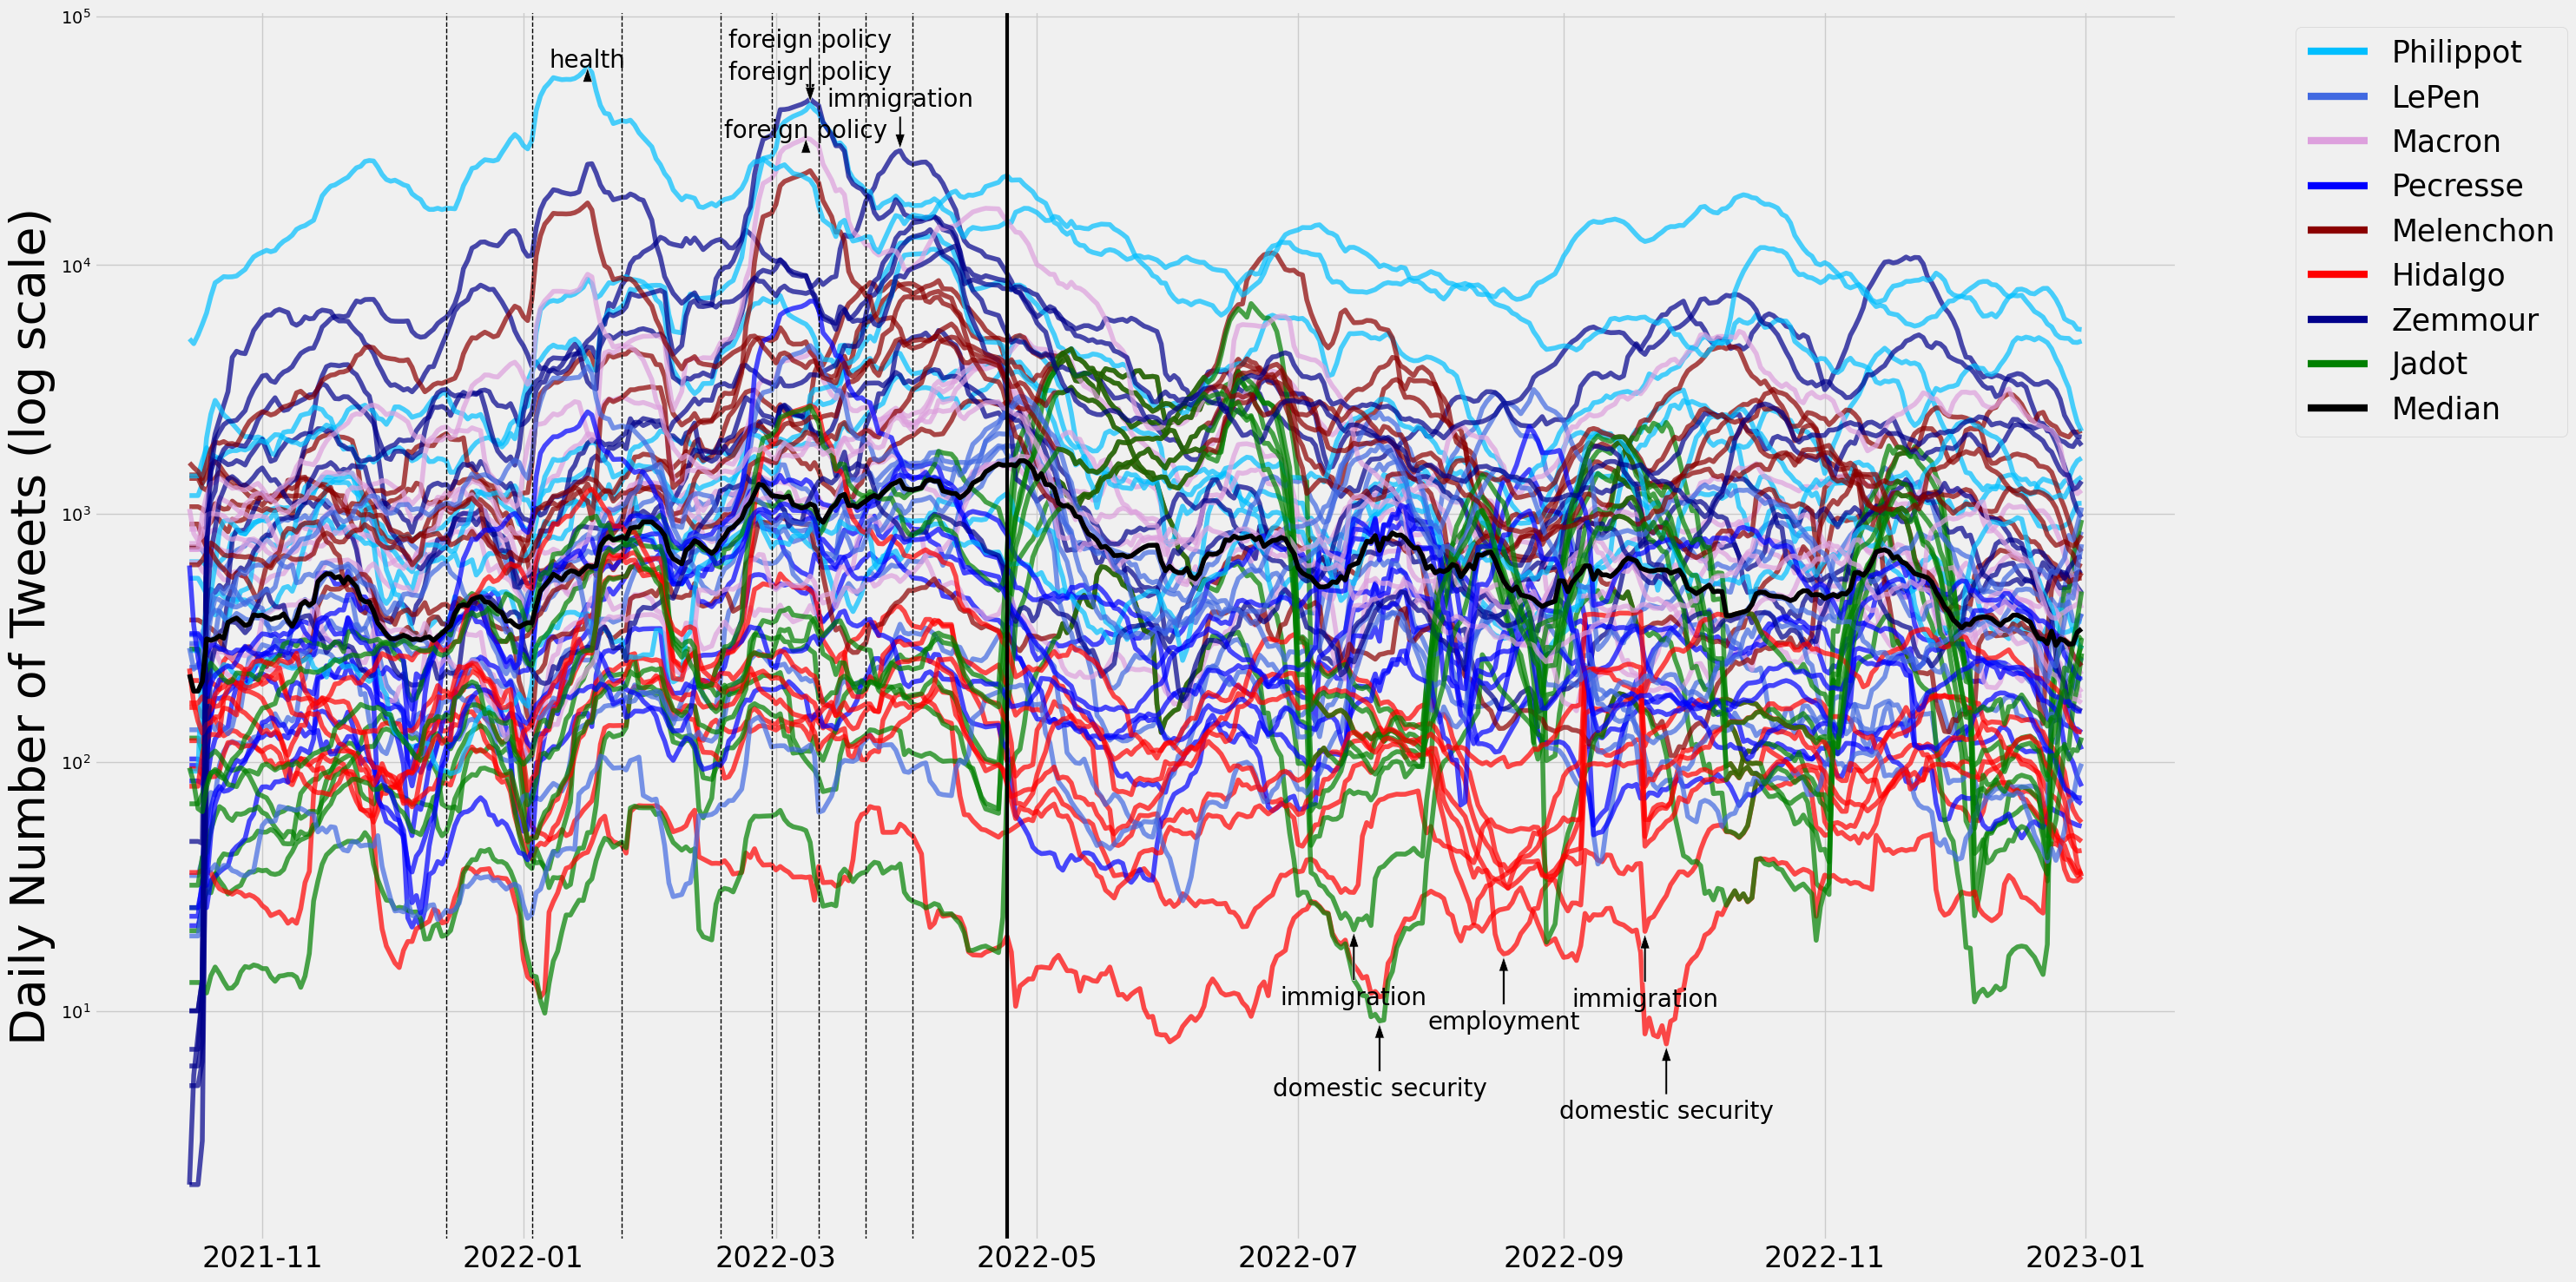

In [5]:
from matplotlib.lines import Line2D
window_size=10
opt=1
time_interest,delta_max_eig_vals,time_split,dic_keynodes = compute_dynamics_changes(dfreturn, window_size,opt)
# Add vertical lines for specific events
event_dates = ['2022-04-24', '2022-04-10']  # Dates of the events
event_labels = ['election', '1st round election']  # Labels for the events



fig1, ax1 = plt.subplots(figsize=(30, 15))  # Adjust size as needed

# Upper panel: Smoothed time series
for col in df_smoothed.columns:
    candidate = col.split('-')[0]
    topic = col.split('-')[1]
    if topic == 'economy':
        ax1.plot([dic_date[i] for i in df_smoothed.index], df_smoothed[col], label=candidate, color=dic_col[candidate], alpha=0.7)
    else:
        ax1.plot([dic_date[i] for i in df_smoothed.index], df_smoothed[col], color=dic_col[candidate], alpha=0.7)

median_values = df_smoothed.median(axis=1)
ax1.plot([dic_date[i] for i in df_smoothed.index], median_values, color='black', label='Median', linewidth=4)

for time in time_interest:
    ax1.axvline(x=dic_date[time], color='black', linestyle='--', linewidth=1)

# Event markers
for date, label in zip(event_dates, event_labels):
    for key, value in dic_date.items():
        if value == pd.Timestamp(date):
            ax1.axvline(x=value, color='black', linestyle='-', linewidth=3)

ax1.set_yscale('log')
ax1.set_ylabel("Daily Number of Tweets (log scale)", fontsize=40)

# Legend
custom_lines = [Line2D([0], [0], color=dic_col[c], lw=6, label=c) for c in df_smoothed.columns.str.split('-').str[0].unique()]
custom_lines.append(Line2D([0], [0], color='black', lw=6, label='Median'))

ax1.legend(handles=custom_lines, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=25)

# Annotations: Top and bottom
top_3 = sorted([(df_smoothed.iloc[15:][col].max(), col) for col in df_smoothed.columns], reverse=True)[:5]
bottom_3 = sorted([(df_smoothed.iloc[15:][col].min(), col) for col in df_smoothed.columns])[:5]

x_vals = [dic_date[i] for i in df_smoothed.index]
top_offsets = [1, 1.2, 1.7, 1.0, 1.5]

for idx, (val, col) in enumerate(top_3):
    topic = col.split('-')[1]
    i_peak = df_smoothed[col].values.argmax()
    ax1.annotate(topic, xy=(x_vals[i_peak], val), xytext=(x_vals[i_peak], val * top_offsets[idx]),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8),
                 fontsize=20, ha='center', color='black')

for val, col in bottom_3:
    topic = col.split('-')[1]
    i_low = df_smoothed[col].values.argmin()
    ax1.annotate(topic, xy=(x_vals[i_low], val), xytext=(x_vals[i_low], val * 0.5),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8),
                 fontsize=20, ha='center', color='black')

ax1.tick_params(axis='x', labelsize=24)

plt.tight_layout()
fig1.savefig('fig/TS_2022_communitiesa.png')
plt.show()


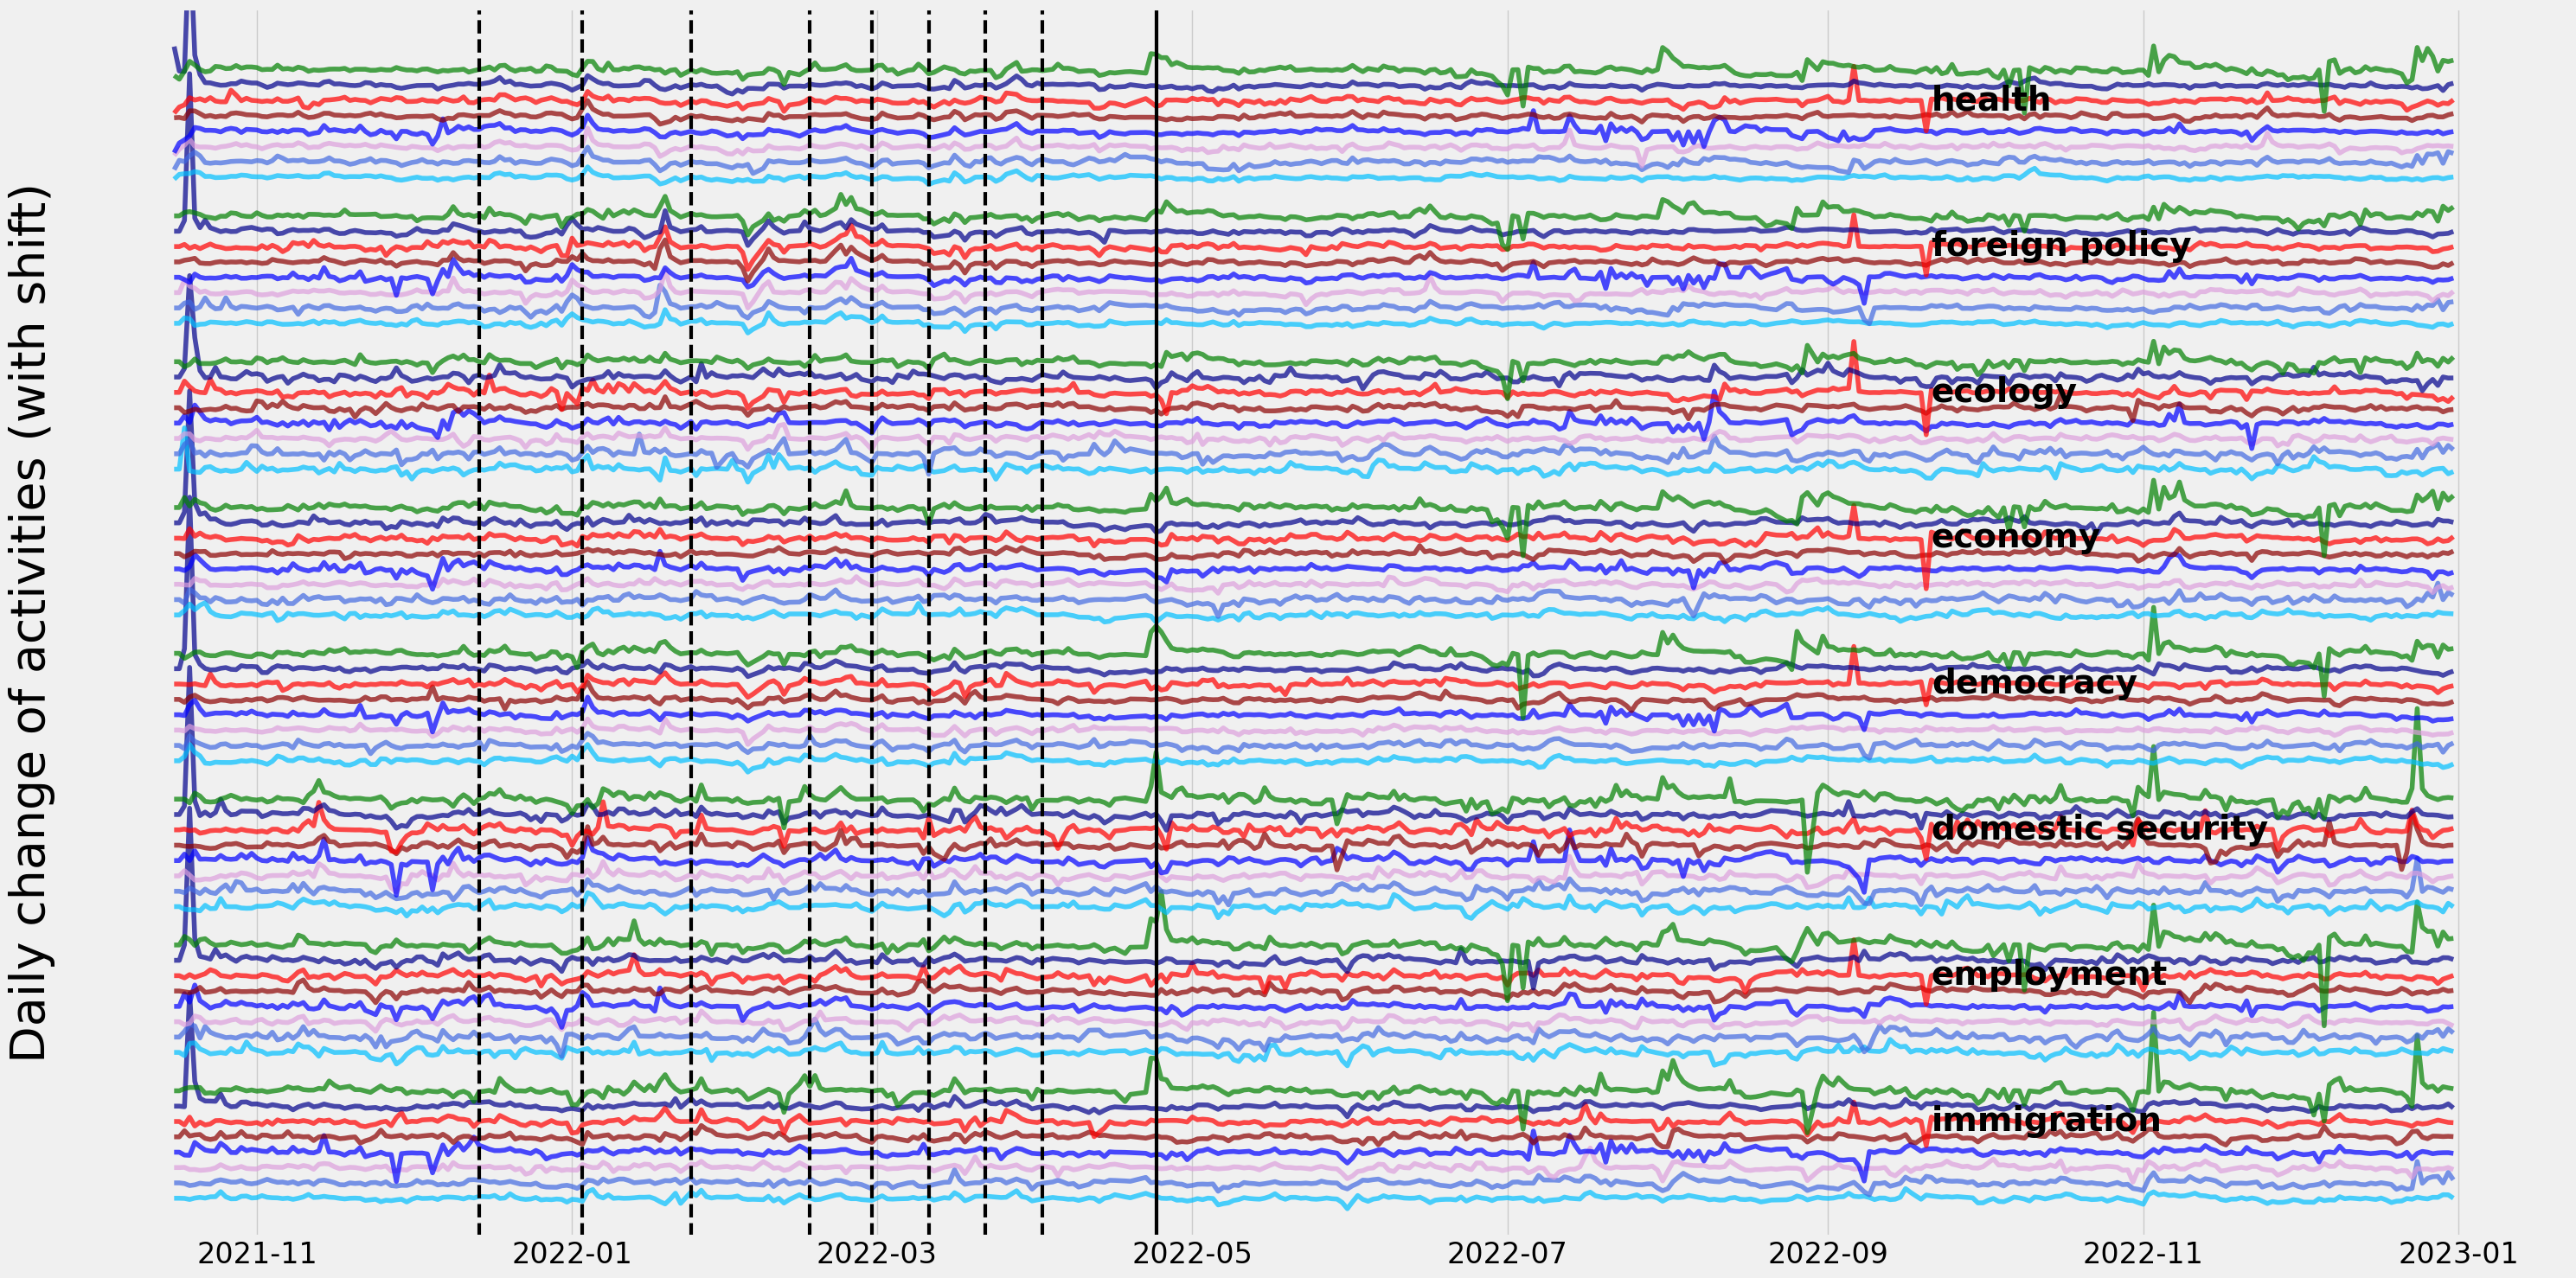

In [6]:
fig2, ax2 = plt.subplots(figsize=(30, 15))  # Adjust size as needed

ic = 0
topslit = []

for col in dfreturn.columns:
    candidate = col.split('-')[0]
    topic = col.split('-')[1]
    
    if topic not in topslit:
        ic += 1
        topslit.append(topic)
        ax2.text(dic_date[325], ic + 2, topic, color='black', fontsize=28,fontweight='bold',  va='center', ha='left')
    else:
        ic += 0.4
    
    y_shifted = dfreturn[col] + ic
    ax2.plot([dic_date[i] for i in dfreturn.index], y_shifted, color=dic_col[candidate], alpha=0.7)

for time in time_interest:
    ax2.axvline(x=dic_date[time], color='black', linestyle='--', linewidth=3)

for date, label in zip(event_dates, event_labels):
    for key, value in dic_date.items():
        if value == pd.Timestamp(date):
            ax2.axvline(x=value, color='black', linestyle='-', linewidth=3)

ax2.set_ylabel("Daily change of activities (with shift)", fontsize=40)
ax2.set_ylim([0, 32])
ax2.set_yticks([])
ax2.tick_params(axis='y', length=0)
ax2.tick_params(axis='x', labelsize=24)

plt.tight_layout()
fig2.savefig('fig/TS_2022_communitiesab.png')
plt.show()


/var/folders/8x/k29py3592yb30gxb21nqnbz40000gn/T/ipykernel_42262/3246445031.py:138: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  corr_matrix_op = df_multi.groupby(level=0).mean().groupby(level=0, axis=1).mean()
/var/folders/8x/k29py3592yb30gxb21nqnbz40000gn/T/ipykernel_42262/3246445031.py:138: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  corr_matrix_op = df_multi.groupby(level=0).mean().groupby(level=0, axis=1).mean()
/var/folders/8x/k29py3592yb30gxb21nqnbz40000gn/T/ipykernel_42262/3246445031.py:138: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  corr_matrix_op = df_multi.groupby(level=0).mean().groupby(level=0, axis=1).mean()
/var/folders/8x/k29py3592yb30gxb21nqnbz40000gn/T/ipykernel_42262/3246445031.py:138: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` wi

2021-10-15 00:00:00 health
2021-10-25 00:00:00 health
2021-11-04 00:00:00 employment
2021-11-14 00:00:00 domestic security
2021-11-24 00:00:00 domestic security
2021-12-04 00:00:00 foreign policy
2021-12-14 00:00:00 employment
2021-12-24 00:00:00 health
2022-01-03 00:00:00 health
2022-01-13 00:00:00 foreign policy
2022-01-24 00:00:00 foreign policy
2022-02-04 00:00:00 foreign policy
2022-02-16 00:00:00 health
2022-02-28 00:00:00 foreign policy
2022-03-11 00:00:00 foreign policy
2022-03-22 00:00:00 health
2022-04-02 00:00:00 foreign policy
2022-04-14 00:00:00 ecology
2022-04-27 00:00:00 foreign policy
2022-05-07 00:00:00 health
2022-05-17 00:00:00 foreign policy
2022-05-27 00:00:00 employment
2022-06-06 00:00:00 domestic security
2022-06-16 00:00:00 foreign policy
2022-06-26 00:00:00 foreign policy
2022-07-06 00:00:00 health
2022-07-16 00:00:00 democracy
2022-07-26 00:00:00 health
2022-08-05 00:00:00 ecology
2022-08-15 00:00:00 employment
2022-08-26 00:00:00 ecology
2022-09-06 00:00:00 

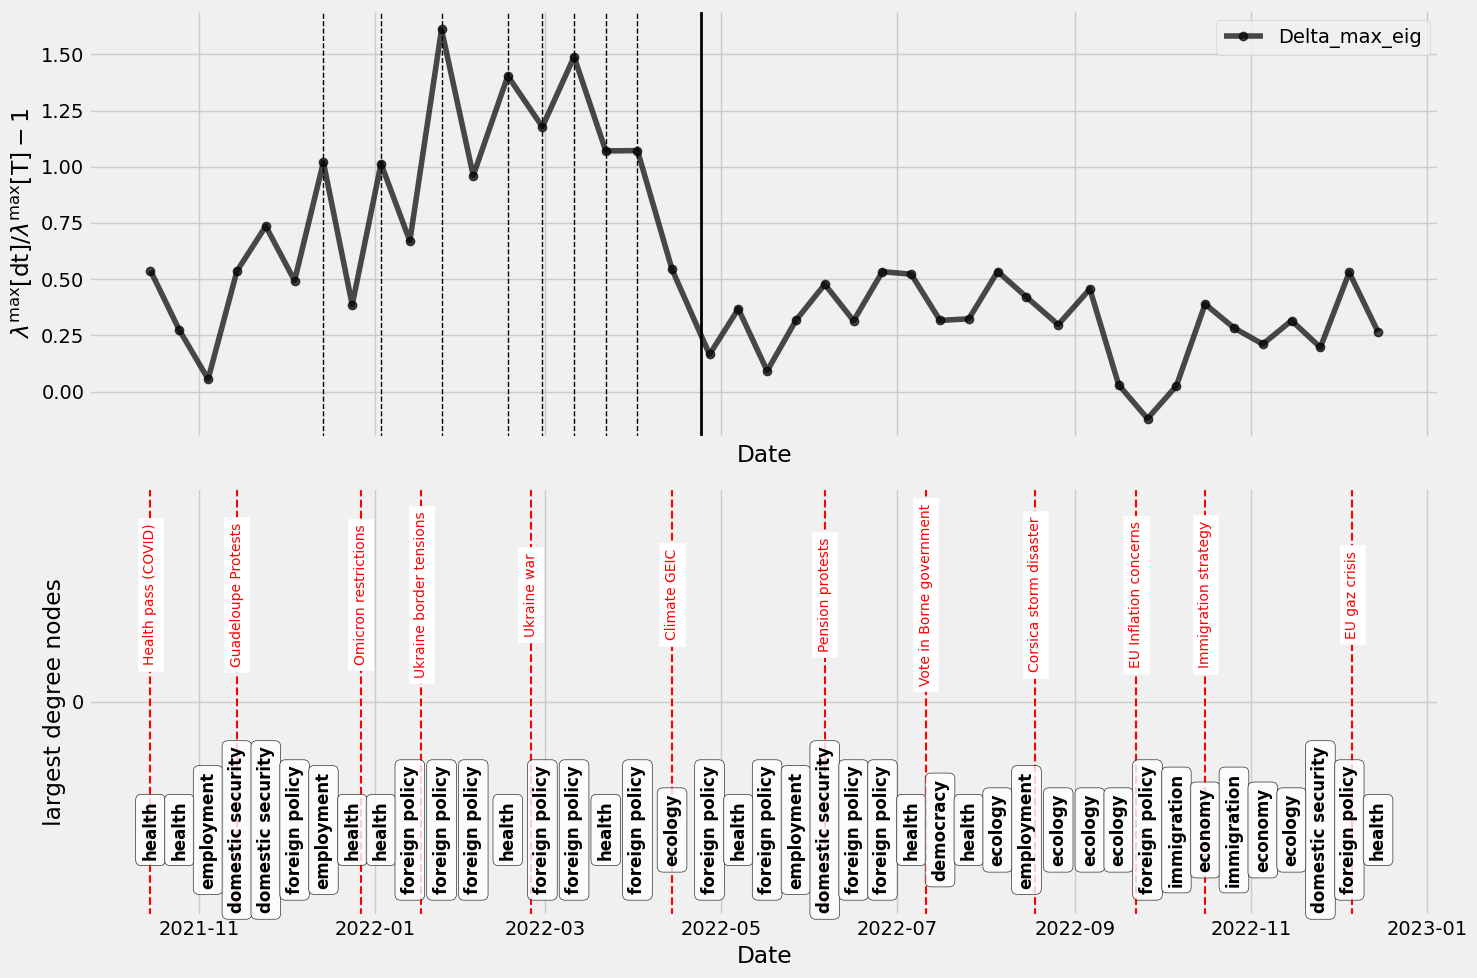

In [7]:
time_interest,delta_max_eig_vals,time_split,dic_keynodes = compute_dynamics_changes(dfreturn, window_size,3)
event_real_dates = {
    'Health pass (COVID)': pd.Timestamp('2021-10-14'),
    'Guadeloupe Protests': pd.Timestamp('2021-11-14'),
  #  'Guadeloupe Unrest Continues': pd.Timestamp('2021-11-24'),
    'Omicron restrictions': pd.Timestamp('2021-12-27'),
   # 'Public mask mandate returns': pd.Timestamp('2022-01-03'),
    'Ukraine border tensions': pd.Timestamp('2022-01-17'),
    'Ukraine war': pd.Timestamp('2022-02-24'),
   # 'France boosts defense': pd.Timestamp('2022-03-11'),
    'Climate GEIC': pd.Timestamp('2022-04-14'),
    'Pension protests': pd.Timestamp('2022-06-06'),
 
    'Vote in Borne government': pd.Timestamp('2022-07-11'),
    'Corsica storm disaster': pd.Timestamp('2022-08-18'),
    'EU Inflation concerns': pd.Timestamp('2022-09-22'),
    
    'Immigration strategy': pd.Timestamp('2022-10-16'),
   
    
    'EU gaz crisis': pd.Timestamp('2022-12-06'),
    
}


# Create a figure 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)


# Lower panel for delta_max_eig_vals
ax[0].plot([dic_date[time] for time in time_split], delta_max_eig_vals, '-o',color='black', label='Delta_max_eig', alpha=0.7)

# Add vertical lines at the time_interest values for the lower panel as well
for time in time_interest:
    ax[0].axvline(x=dic_date[time], color='black', linestyle='--', linewidth=1)

# Add vertical lines for specific events in the lower panel
for date, label in zip(event_dates, event_labels):
    event_key = None
    for key, value in dic_date.items():
        if value == pd.Timestamp(date):
            event_key = key
            break
    if event_key is not None:
        ax[0].axvline(x=dic_date[event_key], color='black', linestyle='-', linewidth=2)

# Labels and legend for the lower panel
ax[0].set_ylabel(r"$\lambda^{\max}[\mathrm{dt}]/\lambda^{\max}[\mathrm{T}]-1$")
ax[0].set_xlabel("Date")
ax[0].legend(loc='upper right')






# Map category to y-coordinate
key_order = ['eig']
key_to_y = {key: i for i, key in enumerate(key_order)}

# Plot the candidate-topic string at the corresponding time
for i, time in enumerate(time_split):
    for key in key_order:
        if i < len(dic_keynodes[key]):
            label = dic_keynodes[key][i][0]  # Extract the 'Candidate-topic' string from the inner list
            topic = label.split('-')[0]
            #topic = label.split('-')[1]
            ax[1].text(
                dic_date[time],
                key_to_y[key]-0.3,
                topic,
                fontsize=12,
                fontweight='bold',
                ha='center',
                va='center',
                rotation=90,
                color='black',
                #bbox=dict(boxstyle='round,pad=0.35', facecolor=dic_col[candidate], edgecolor='black', alpha=0.8)
                bbox=dict(boxstyle='round,pad=0.35', facecolor='white', edgecolor='black', alpha=0.8)
            )
            print(dic_date[time],topic)




# Find the closest 'time' keys in dic_date for each event date
event_times = {}
for label, event_date in event_real_dates.items():
    # dic_date maps integer time keys to timestamps, so find closest integer key:
    closest_time = min(dic_date.keys(), key=lambda t: abs(dic_date[t] - event_date))
    event_times[closest_time] = label

for time, label in event_times.items():
    x = dic_date[time]

    # Add vertical red dashed line
    ax[1].axvline(x=x, color='red', linestyle='--', linewidth=1.5)

    # Add text annotation (rotated vertical)
    y_pos = key_to_y['eig'] + 0.25  # Slightly above the node band

    ax[1].text(
    x,
    y_pos,
    label,
    rotation=90,
    verticalalignment='center',
    horizontalalignment='center',
    fontsize=10,
    color='red',
    backgroundcolor='white'
    )


# Format the bottom plot
ax[1].set_yticks(list(key_to_y.values()))
#ax[1].set_yticklabels(key_order)
ax[1].set_ylim(-0.5, len(key_order)-0.5)
ax[1].set_ylabel("largest degree nodes")
ax[1].set_xlabel("Date")


# Adjust layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()

# Save the figure
fig.savefig('fig/TS_2022_lmaxratio.png')

In [ ]:
# Target date to find
target_date = pd.Timestamp('2022-04-24')
# Find the key corresponding to the target date
keydate = next((k for k, v in dic_date.items() if v == target_date), None)
print(keydate)



177
Louvain communities:
Community 0 has 1 nodes: ['Melenchon-immigration']
Community 1 has 8 nodes: ['Zemmour-democracy', 'Zemmour-domestic security', 'Zemmour-ecology', 'Zemmour-economy', 'Zemmour-employment', 'Zemmour-foreign policy', 'Zemmour-health', 'Zemmour-immigration']
Community 2 has 2 nodes: ['Melenchon-economy', 'Philippot-economy']
Community 3 has 1 nodes: ['Philippot-ecology']
Community 4 has 2 nodes: ['LePen-ecology', 'Macron-ecology']
Community 5 has 50 nodes: ['Hidalgo-democracy', 'Hidalgo-domestic security', 'Hidalgo-ecology', 'Hidalgo-economy', 'Hidalgo-employment', 'Hidalgo-foreign policy', 'Hidalgo-health', 'Hidalgo-immigration', 'Jadot-democracy', 'Jadot-domestic security', 'Jadot-ecology', 'Jadot-economy', 'Jadot-employment', 'Jadot-foreign policy', 'Jadot-health', 'Jadot-immigration', 'LePen-democracy', 'LePen-domestic security', 'LePen-economy', 'LePen-employment', 'LePen-foreign policy', 'LePen-health', 'LePen-immigration', 'Macron-democracy', 'Macron-domestic

100%|████████████████████████████████████| 5000/5000 [00:00<00:00, 13080.07it/s]


BarnesHut Approximation  took  0.08  seconds
Repulsion forces  took  0.21  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds
Centrality measures for top nodes:
Node: Jadot-ecology
  Betweenness: 0.1295
  Degree: 2.5815
  Closeness: 0.3864
-------------------------------
Node: Macron-democracy
  Betweenness: 0.1214
  Degree: 6.4868
  Closeness: 0.4205
-------------------------------
Node: Macron-democracy
  Betweenness: 0.1214
  Degree: 6.4868
  Closeness: 0.4205
-------------------------------


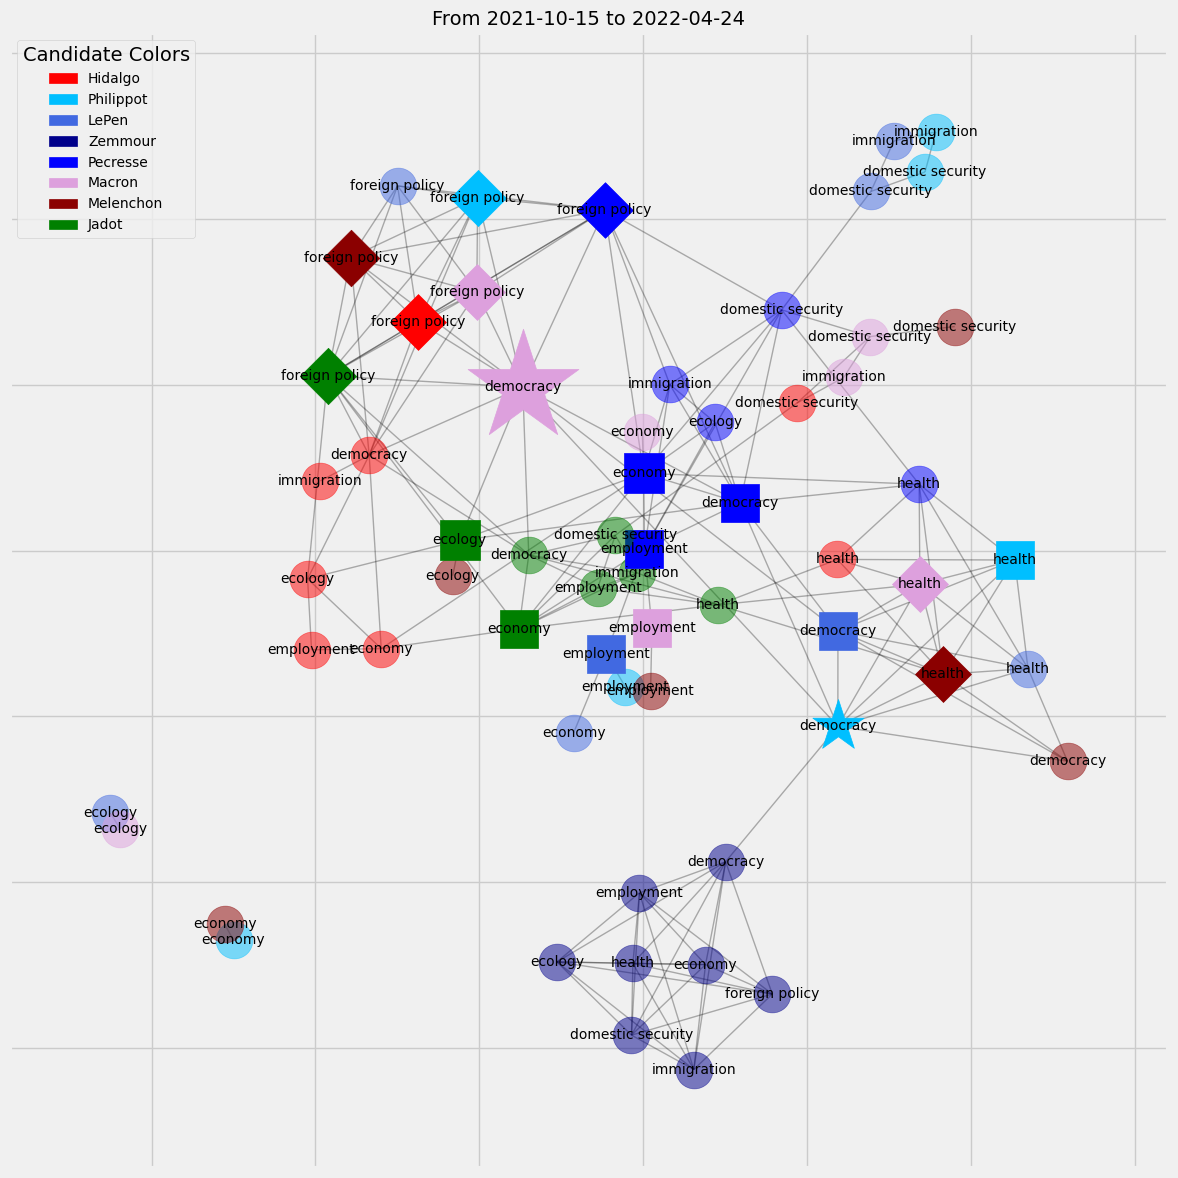

In [9]:
# before the election 
significant_corr_matrix = dfreturn.iloc[:keydate].corr()


# Apply mask for values below the 90th percentile of absolute values
mask_value = np.quantile(np.abs(significant_corr_matrix.values.flatten()), 0.9)
masked_matrix = significant_corr_matrix[np.abs(significant_corr_matrix) >= mask_value]
masked_matrix = masked_matrix.fillna(0)
# Create a graph from the adjacency matrix
masked_matrix = masked_matrix.replace(1, 0)
timedate=str(dic_date[0])+'_'+str(dic_date[keydate])
make_graph_undir(masked_matrix, 10,timedate,dic_col)
adj_pre_election=masked_matrix

Louvain communities:
Community 0 has 8 nodes: ['Hidalgo-democracy', 'Hidalgo-domestic security', 'Hidalgo-ecology', 'Hidalgo-economy', 'Hidalgo-employment', 'Hidalgo-foreign policy', 'Hidalgo-health', 'Hidalgo-immigration']
Community 1 has 1 nodes: ['Melenchon-domestic security']
Community 2 has 47 nodes: ['LePen-democracy', 'LePen-domestic security', 'LePen-ecology', 'LePen-economy', 'LePen-employment', 'LePen-foreign policy', 'LePen-health', 'LePen-immigration', 'Macron-democracy', 'Macron-domestic security', 'Macron-ecology', 'Macron-economy', 'Macron-employment', 'Macron-foreign policy', 'Macron-health', 'Macron-immigration', 'Melenchon-democracy', 'Melenchon-ecology', 'Melenchon-economy', 'Melenchon-employment', 'Melenchon-foreign policy', 'Melenchon-health', 'Melenchon-immigration', 'Pecresse-democracy', 'Pecresse-domestic security', 'Pecresse-ecology', 'Pecresse-economy', 'Pecresse-employment', 'Pecresse-foreign policy', 'Pecresse-health', 'Pecresse-immigration', 'Philippot-demo

100%|████████████████████████████████████| 5000/5000 [00:00<00:00, 12841.06it/s]


BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.21  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds
Centrality measures for top nodes:
Node: Melenchon-democracy
  Betweenness: 0.0389
  Degree: 2.7219
  Closeness: 0.2468
-------------------------------
Node: Philippot-employment
  Betweenness: 0.0067
  Degree: 2.7880
  Closeness: 0.1694
-------------------------------
Node: Melenchon-democracy
  Betweenness: 0.0389
  Degree: 2.7219
  Closeness: 0.2468
-------------------------------


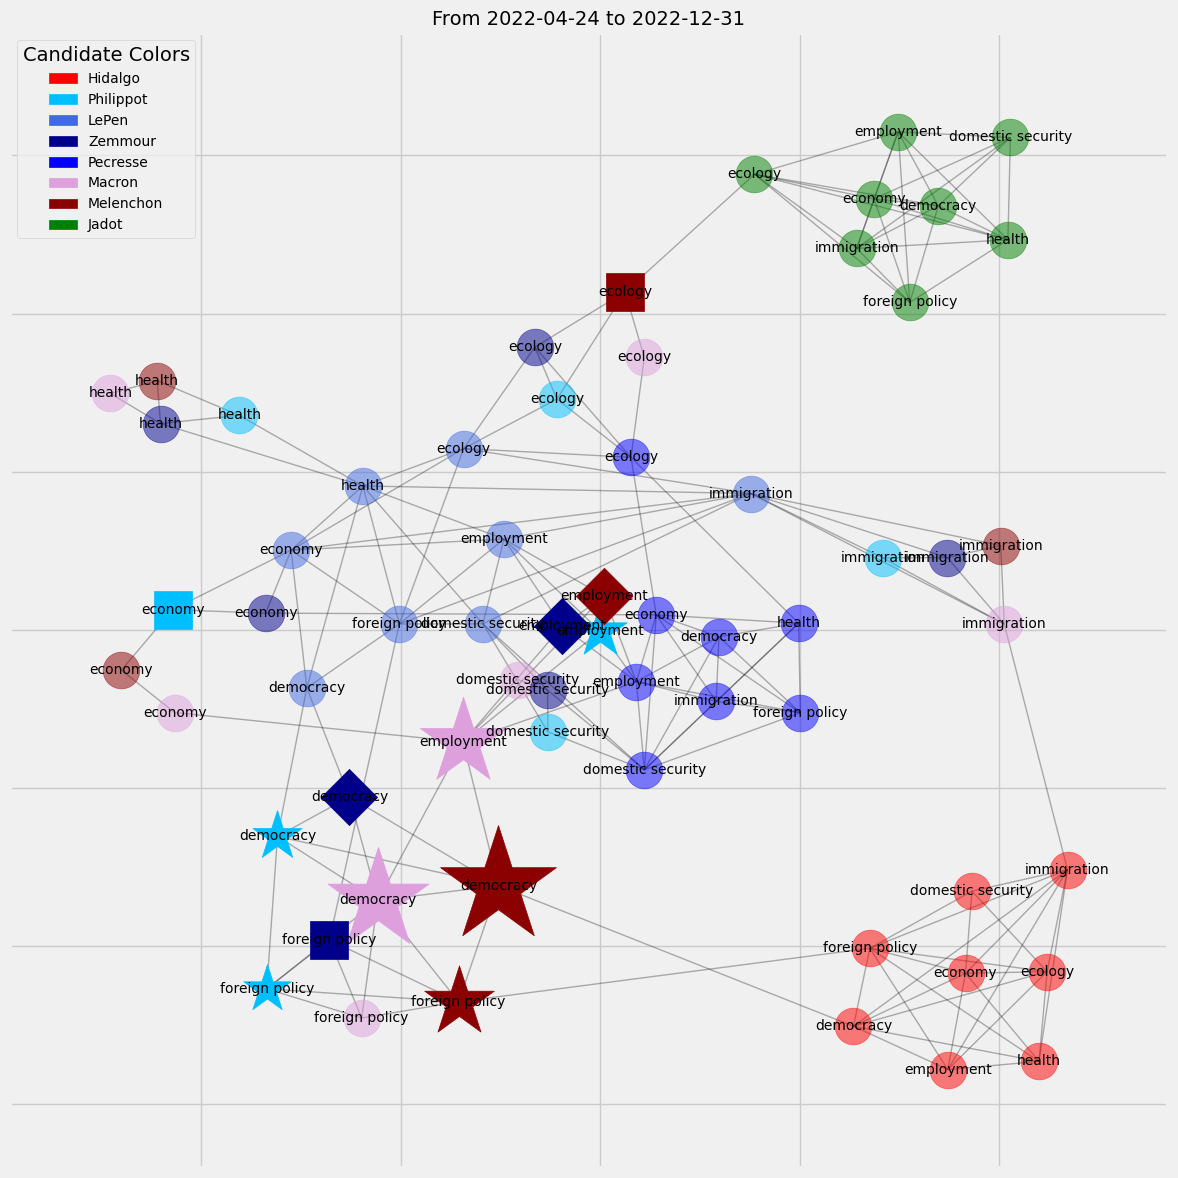

In [10]:
# After election 
significant_corr_matrix = dfreturn.iloc[keydate:].corr()


# Apply mask for values below the 90th percentile of absolute values
mask_value = np.quantile(np.abs(significant_corr_matrix.values.flatten()), 0.9)
masked_matrix = significant_corr_matrix[np.abs(significant_corr_matrix) >= mask_value]
masked_matrix = masked_matrix.fillna(0)
# Create a graph from the adjacency matrix
masked_matrix = masked_matrix.replace(1, 0)
timedate=str(dic_date[keydate])+'_'+str(dic_date[len(dic_date)-1])
make_graph_undir(masked_matrix, 9,timedate,dic_col)
adj_pre_election=masked_matrix

0.242
LePen-immigration LePen-domestic security
LePen-immigration LePen-health
Pecresse-immigration Pecresse-employment
Pecresse-immigration Pecresse-domestic security
Pecresse-immigration Pecresse-democracy
Pecresse-immigration Pecresse-economy
Pecresse-immigration Pecresse-foreign policy
Pecresse-immigration Pecresse-education research
Pecresse-immigration Pecresse-health
Pecresse-immigration Pecresse-energy policy
Hidalgo-immigration Hidalgo-employment
Zemmour-immigration Zemmour-employment
Zemmour-immigration Zemmour-domestic security
Zemmour-immigration Zemmour-democracy
Zemmour-immigration Zemmour-economy
Zemmour-immigration Zemmour-ecology
Zemmour-immigration Zemmour-health
Jadot-immigration Jadot-employment
Jadot-immigration Jadot-domestic security
Jadot-immigration Jadot-democracy
Jadot-immigration Jadot-economy
Jadot-immigration Jadot-ecology
Jadot-immigration Jadot-foreign policy
Jadot-immigration Jadot-education research
Jadot-immigration Jadot-health
LePen-employment LePen

100%|█████████████████████████████████████| 5000/5000 [00:00<00:00, 9000.97it/s]


BarnesHut Approximation  took  0.11  seconds
Repulsion forces  took  0.33  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds
percentile_85 0.5025499999999999
Centrality measures for top nodes:
Node: Macron-health
  Betweenness: 0.2128
  Degree: 6.9920
  Closeness: 0.9761
-------------------------------
Node: Melenchon-foreign policy
  Betweenness: 0.0755
  Degree: 10.3850
  Closeness: 0.8896
-------------------------------
Node: Macron-health
  Betweenness: 0.2128
  Degree: 6.9920
  Closeness: 0.9761
-------------------------------


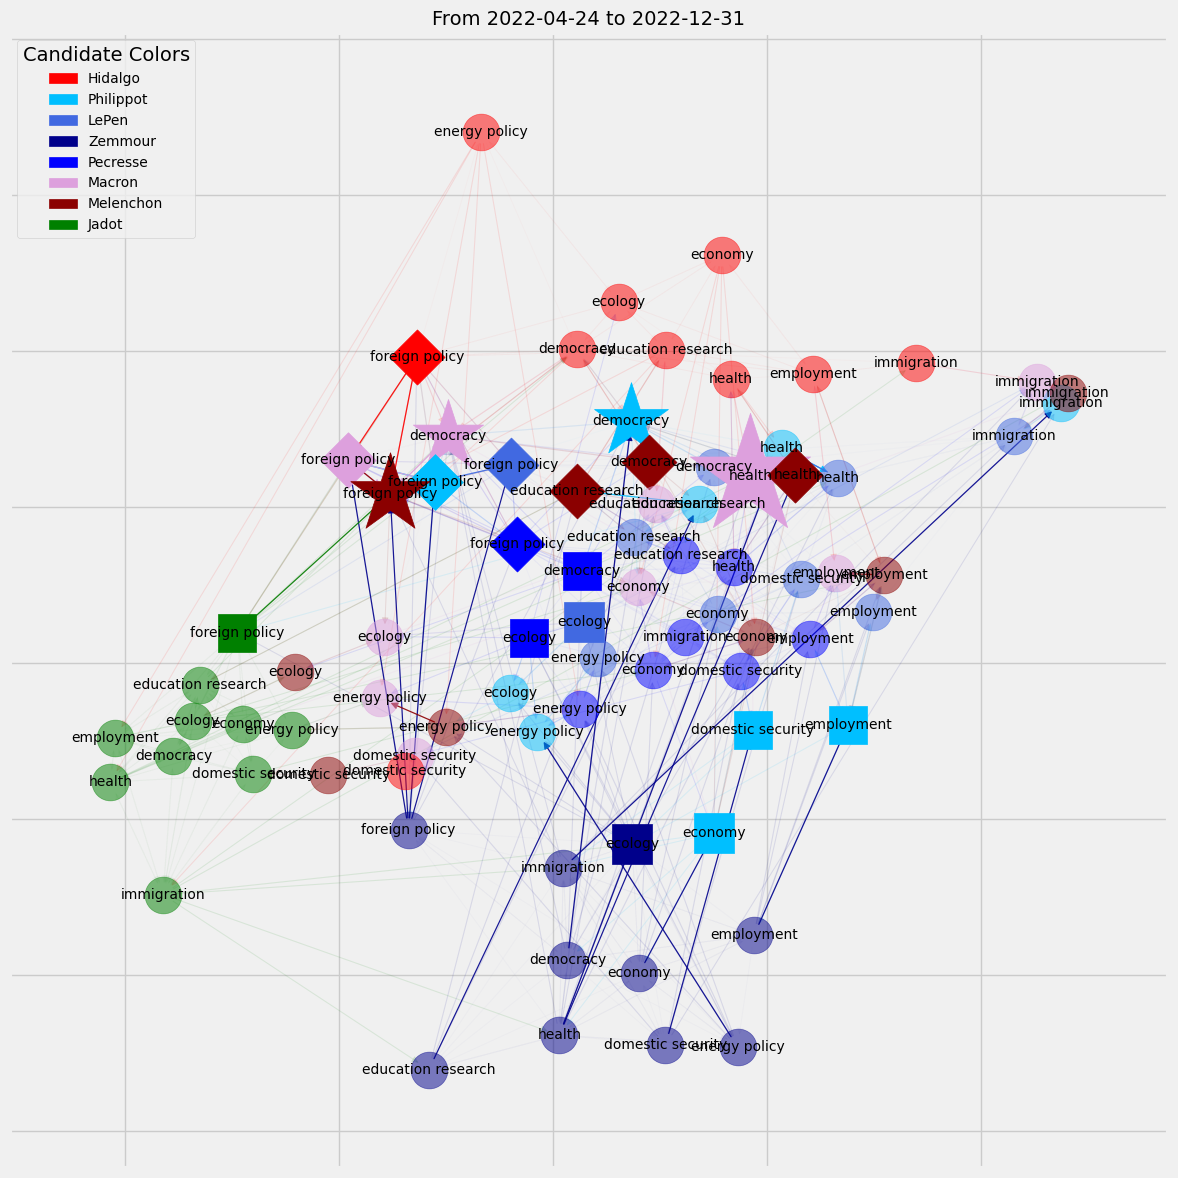

In [12]:
keywords =list(translations.values())

# Use str.contains() to filter columns containing any of the keywords
selected_columns = df2.columns[df2.columns.str.contains('|'.join(keywords))]
# Create a new DataFrame with the selected columns
df3 = df2[selected_columns].iloc[:]

df_smoothed=rolling_mean_dataframe(df3,window=W)
dfreturn=np.log(df_smoothed/df_smoothed.shift(1))
dfreturn.dropna(inplace=True)
#for cand in dfreturn.columns:
#    plt.plot(dfreturn[cand],label=cand)

max_lag=5


writefile=0
if writefile==1:
    corrM,lag_matrix=computeCCM_matrix(dfreturn, max_lag)
    # Save the TE and Lag matrices to CSV files
    corrM.to_csv('data/CCM_matrix.csv', index=True)
    lag_matrix.to_csv('data/CCMlag_matrix.csv', index=True)
else:
    corrM = pd.read_csv('data/CCM_matrix.csv', index_col=0)
    lag_matrix = pd.read_csv('data/CCMlag_matrix.csv', index_col=0)
#corrM,lag_matrix=computeCCM_matrix(dfreturn,max_lag)

median_value = np.quantile(np.array(corrM).ravel(),0.5) 
filtered_CorrM = corrM[np.abs(corrM) >= median_value]
filtered_CorrM = filtered_CorrM.fillna(0)
aggregated_matrix = aggregate_percand(filtered_CorrM)
aggregated_lagmatrix = aggregate_percand(lag_matrix)

#### thresho methods
median_value = np.quantile(np.array(corrM).ravel(),0.9)  
print(median_value)
# Filter values below the median
filtered_CorrM = corrM[np.abs(corrM) >= median_value]
filtered_CorrM = filtered_CorrM.fillna(0)
# Create a graph from the adjacency matrix
filtered_CorrM = filtered_CorrM.replace(1, 0)



# optional remove influence on party_i topic_a on party_i topic_b: 
# Extract candidate names from column names (everything before the '-')
candidates_in_columns = [col.split('-')[0] for col in filtered_CorrM.columns]
for index, row in filtered_CorrM.iterrows():
    # Extract the candidate's name from the row index (assuming format is 'candidate-topic')
    candidate_name = index.split('-')[0]
    
    # Loop through the columns and zero out the columns for the same candidate if they are non-zero
    for col in filtered_CorrM.columns:
        # Extract the candidate from the column name (assuming format is 'candidate-topic')
        col_candidate_name = col.split('-')[0]
        
        # Check if the column belongs to the same candidate and if the value is non-zero
        if col_candidate_name == candidate_name and row[col] != 0:
            # Set the value of that column to 0 for the current row
            #filtered_CorrM.at[index, col] = 0
            print(index,col)



kspatial=6
save_path='fig/CCM_graph.png'
seedi=12#12
namedate=str(dic_date[0].date())+'_'+str(dic_date[len(dic_date)-1].date())
namedate=str(dic_date[0].date())+'_'+str(dic_date[keydate-1].date())


lagdisplay=0
#make_graph_large_components(filtered_CorrM, kspatial, save_path, lag_matrix, seedi, namedate, lagdisplay,dic_col)
#make_graph_largest_component(filtered_CorrM, kspatial, save_path, lag_matrix, seedi, namedate, lagdisplay,dic_col)
make_graph_bidir(filtered_CorrM, 1,timedate,dic_col)

0.242


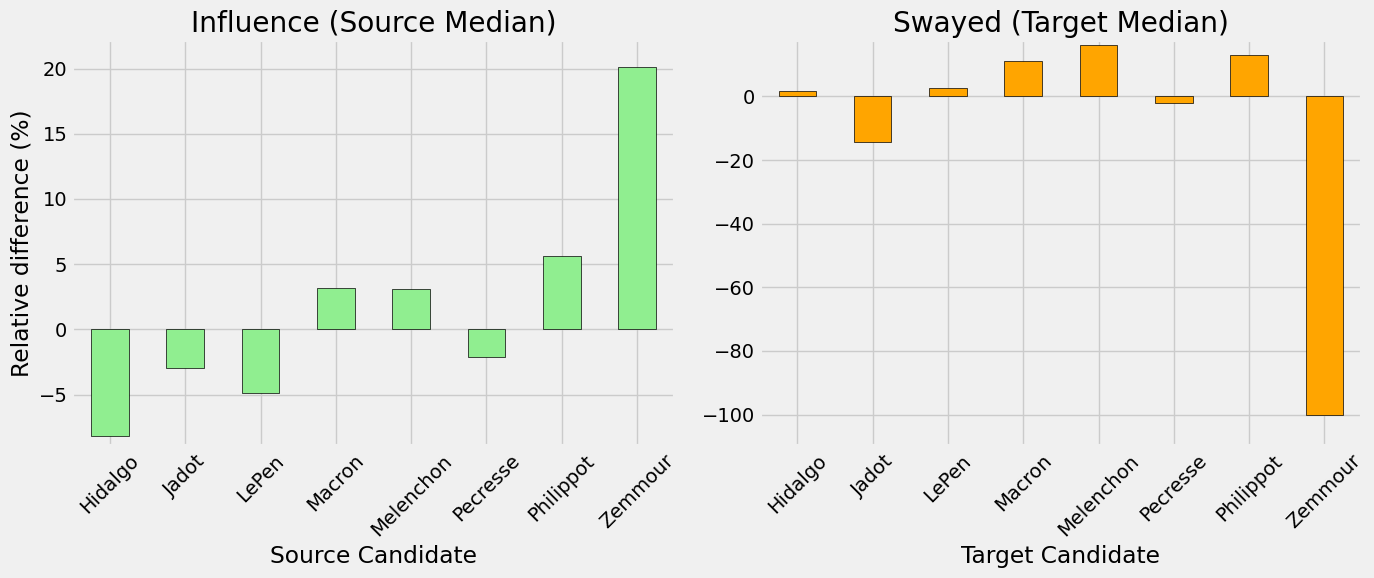

In [14]:
#  remove influence on party_i topic_a on party_i topic_b: 


median_value = np.quantile(np.array(corrM).ravel(),0.90) 
print(median_value)
filtered_CorrM = corrM[np.abs(corrM) >= median_value]
filtered_CorrM = filtered_CorrM.fillna(0)
filtered_CorrM_noselfinfluence=np.abs(filtered_CorrM.copy())

# Extract candidate names from column names (everything before the '-')
candidates_in_columns = [col.split('-')[0] for col in filtered_CorrM.columns]
for index, row in filtered_CorrM.iterrows():
    # Extract the candidate's name from the row index (assuming format is 'candidate-topic')
    candidate_name = index.split('-')[0]
    
    # Loop through the columns and zero out the columns for the same candidate if they are non-zero
    for col in filtered_CorrM.columns:
        # Extract the candidate from the column name (assuming format is 'candidate-topic')
        col_candidate_name = col.split('-')[0]
        
        # Check if the column belongs to the same candidate and if the value is non-zero
        if col_candidate_name == candidate_name and row[col] != 0:
            # Set the value of that column to 0 for the current row
            filtered_CorrM_noselfinfluence.at[index, col] = 0



aggregated_matrix = aggregate_causal_impact(filtered_CorrM_noselfinfluence)

# Calculate the relative un/influence using median
source_med_entropy = (aggregated_matrix.median(axis=1) / np.median(aggregated_matrix).ravel() - 1) * 100
target_med_influence = (aggregated_matrix.median(axis=0) / np.median(aggregated_matrix).ravel() - 1) * 100

# Create a 1x2 subplot layout for the medians
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# --- Left subplot: Median (source) ---
source_med_entropy.plot(kind='bar', color='lightgreen', edgecolor='black', ax=axes[0])
axes[0].set_title('Influence (Source Median)')
axes[0].set_xlabel('Source Candidate')
axes[0].set_ylabel('Relative difference (%)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(min(source_med_entropy) * 1.1, max(source_med_entropy) * 1.1)

# --- Right subplot: Median (target) ---
target_med_influence.plot(kind='bar', color='orange', edgecolor='black', ax=axes[1])
axes[1].set_title('Swayed (Target Median)')
axes[1].set_xlabel('Target Candidate')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(min(target_med_influence) * 1.1, max(target_med_influence) * 1.1)

# Adjust layout and display
plt.tight_layout()
plt.show()
fig.savefig('fig/relative_influence_CCM.png')


0.242


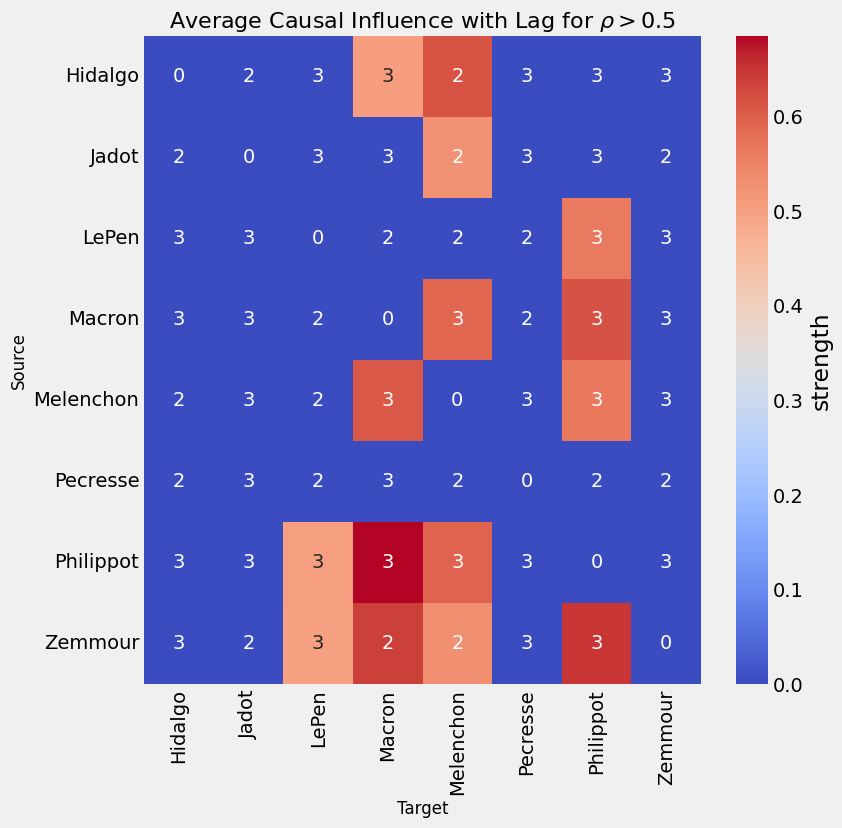

In [15]:
median_value = np.quantile(np.array(corrM).ravel(),0.9)
print(median_value)
filtered_CorrM = corrM[np.abs(corrM) >= 0.5]
filtered_CorrM = filtered_CorrM.fillna(0)
filtered_CorrM_noselfinfluence=np.abs(filtered_CorrM.copy())

# Extract candidate names from column names (everything before the '-')
candidates_in_columns = [col.split('-')[0] for col in filtered_CorrM.columns]
for index, row in filtered_CorrM.iterrows():
    # Extract the candidate's name from the row index (assuming format is 'candidate-topic')
    candidate_name = index.split('-')[0]
    
    # Loop through the columns and zero out the columns for the same candidate if they are non-zero
    for col in filtered_CorrM.columns:
        # Extract the candidate from the column name (assuming format is 'candidate-topic')
        col_candidate_name = col.split('-')[0]
        
        # Check if the column belongs to the same candidate and if the value is non-zero
        if col_candidate_name == candidate_name and row[col] != 0:
            # Set the value of that column to 0 for the current row
            filtered_CorrM_noselfinfluence.at[index, col] = 0



aggregated_matrix = aggregate_causal_impact(filtered_CorrM_noselfinfluence)

mean_val = aggregated_matrix.values.mean()
max_dev = max(abs(aggregated_matrix.values.min() - mean_val), abs(aggregated_matrix.values.max() - mean_val))

# Apply linear transformation: mean -> 0.5, scale values
scaled_matrix = (aggregated_matrix - mean_val) / (2 * max_dev) + 0.5

# Apply non-linear transformation (e.g., exponential scaling)
# This amplifies the differences: small differences are stretched
alpha = 1.5  # Adjust for stronger/weaker amplification
amplified_matrix = 0.5 + np.sign(scaled_matrix - 0.5) * (np.abs(scaled_matrix - 0.5) ** alpha)

# Clip to ensure values remain in [0,1]
amplified_matrix = aggregated_matrix #np.clip(amplified_matrix, 0, 1)

# Convert back to DataFrame
aggregated_matrix = pd.DataFrame(amplified_matrix, 
                                 columns=aggregated_matrix.columns, 
                                 index=aggregated_matrix.index)

fig = plt.figure(figsize=(8, 8))
sns.heatmap(aggregated_matrix, annot=aggregated_lagmatrix, fmt=".0f",cmap='coolwarm', cbar_kws={'label': 'strength'})

# Add labels and title
plt.title(r'Average Causal Influence with Lag for $\rho > 0.5$', fontsize=16)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Source', fontsize=12)

# Show the plot
plt.show()

# Save the figure
fig.savefig('fig/test_causal_aggre.png', dpi=300, bbox_inches='tight')


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


0.242


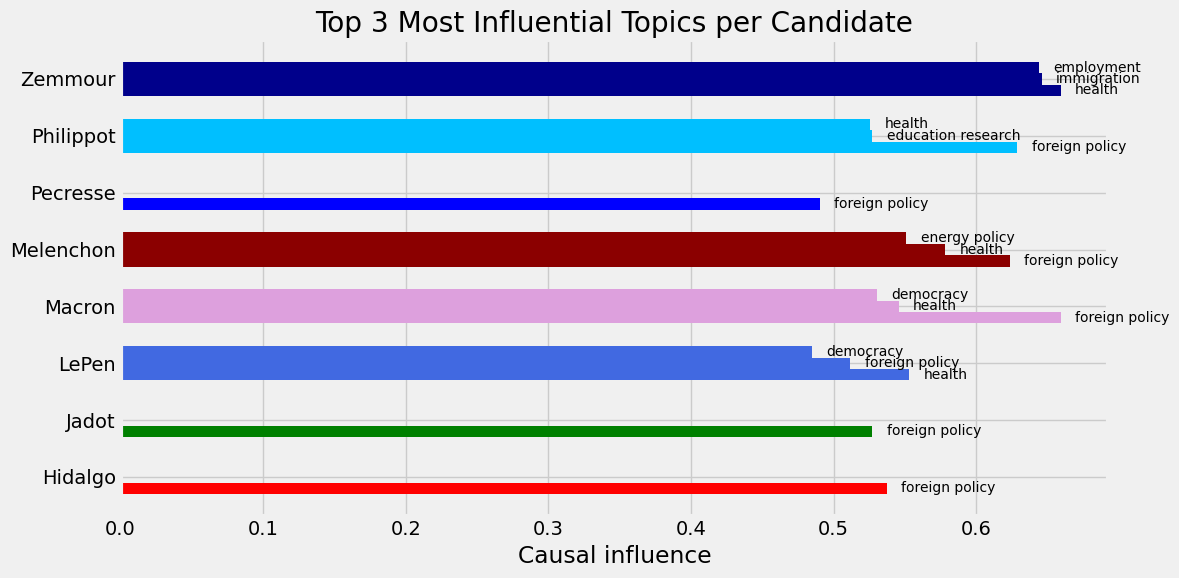

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


In [16]:
# Extract unique candidate names

median_value = np.quantile(np.array(corrM).ravel(),0.9)
print(median_value)
filtered_CorrM = corrM[np.abs(corrM) >= 0.45]
filtered_CorrM = filtered_CorrM.fillna(0)
filtered_CorrM_noselfinfluence=np.abs(filtered_CorrM.copy())

# Extract candidate names from column names (everything before the '-')
candidates_in_columns = [col.split('-')[0] for col in filtered_CorrM.columns]
for index, row in filtered_CorrM.iterrows():
    # Extract the candidate's name from the row index (assuming format is 'candidate-topic')
    candidate_name = index.split('-')[0]
    
    # Loop through the columns and zero out the columns for the same candidate if they are non-zero
    for col in filtered_CorrM.columns:
        # Extract the candidate from the column name (assuming format is 'candidate-topic')
        col_candidate_name = col.split('-')[0]
        
        # Check if the column belongs to the same candidate and if the value is non-zero
        if col_candidate_name == candidate_name and row[col] != 0:
            # Set the value of that column to 0 for the current row
            filtered_CorrM_noselfinfluence.at[index, col] = 0


dft=filtered_CorrM_noselfinfluence
candidate_names = sorted(set(col.split('-')[0] for col in dft.columns))

# Collect top 3 influential topics for each candidate
candidate_influence = {}

for candidate in candidate_names:
    # Get all rows related to the candidate
    candidate_rows = dft.loc[[idx for idx in dft.index if idx.startswith(candidate + '-')]]
    
    # Exclude columns related to the candidate
    target_columns = [col for col in dft.columns if not col.startswith(candidate + '-')]
    
    # Filter the columns
    candidate_rows = candidate_rows[target_columns]
    #candidate_rows['mean']=candidate_rows.mean(axis=1)
    candidate_rows['mean'] = candidate_rows.replace(0, pd.NA).mean(axis=1, skipna=True)
    
    # Step 4: Get the top 3 rows with highest mean values
    top3 = candidate_rows['mean'].sort_values(ascending=False).head(3)
    
    # Step 5: Extract only the topic name (remove the candidate prefix from index)
    clean_top3 = top3.rename(index=lambda x: x.split('-', 1)[1])
    
    # Store result
    candidate_influence[candidate] = clean_top3


# Plot
fig = plt.figure(figsize=(12, 6))


y_pos = np.arange(len(candidate_names))

for idx, candidate in enumerate(candidate_names):
    top_topics = candidate_influence[candidate]
    color = dic_col.get(candidate, 'gray')
    
    for i, (topic_only, value) in enumerate(top_topics.items()):  # topic_only is already clean
        plt.barh(y=idx + i * 0.2, width=value, height=0.2, color=color)
        plt.text(value + 0.01, idx + i * 0.2, topic_only, va='center', ha='left', fontsize=10)

# Y-axis with candidate names
plt.yticks(y_pos + 0.2, candidate_names)
plt.xlabel('Causal influence')
plt.title('Top 3 Most Influential Topics per Candidate')
plt.tight_layout()
plt.show()
fig.savefig('fig/top3_influentialtopics.png', dpi=300, bbox_inches='tight')

In [41]:
# Appendix new testing the parameters of CCM:


def computeCCM_matrix_test(dftemp,max_lag,E):
    # dftemp time series for different columns 
    # return CCM matrix at best lag 

    columns = dftemp.columns
    n_vars = len(dftemp.columns)
    te_matrix = pd.DataFrame(np.zeros((n_vars, n_vars)), index=columns, columns=columns)
    lag_matrix = pd.DataFrame(np.zeros((n_vars, n_vars)), index=columns, columns=columns)
    for source in columns:
        series1=np.array(dftemp[source].tolist())
        for target in columns:
            if source !=target:
                series2=np.array(dftemp[target].tolist())
                corr_CCM = functionccm(series1, series2,max_lag, E=E, k=E+1)
                val=max(corr_CCM.values()) # that's when there is more than one lag 
                key_with_max_value = max(corr_CCM, key=corr_CCM.get)
                te_matrix.loc[source,target]=round(np.max(val),3)
                lag_matrix.loc[source,target]=key_with_max_value
    return te_matrix,lag_matrix


keywords =list(translations.values())

# Use str.contains() to filter columns containing any of the keywords
selected_columns = df2.columns[df2.columns.str.contains('|'.join(keywords))]
# Create a new DataFrame with the selected columns
df3 = df2[selected_columns].iloc[:]

df_smoothed=rolling_mean_dataframe(df3,window=W)
dfreturn=np.log(df_smoothed/df_smoothed.shift(1))
dfreturn.dropna(inplace=True)







In [20]:
len(dfreturn)

426

Pearson correlation: 0.9002796694203793
Relative Frobenius difference: 0.3040356723072454


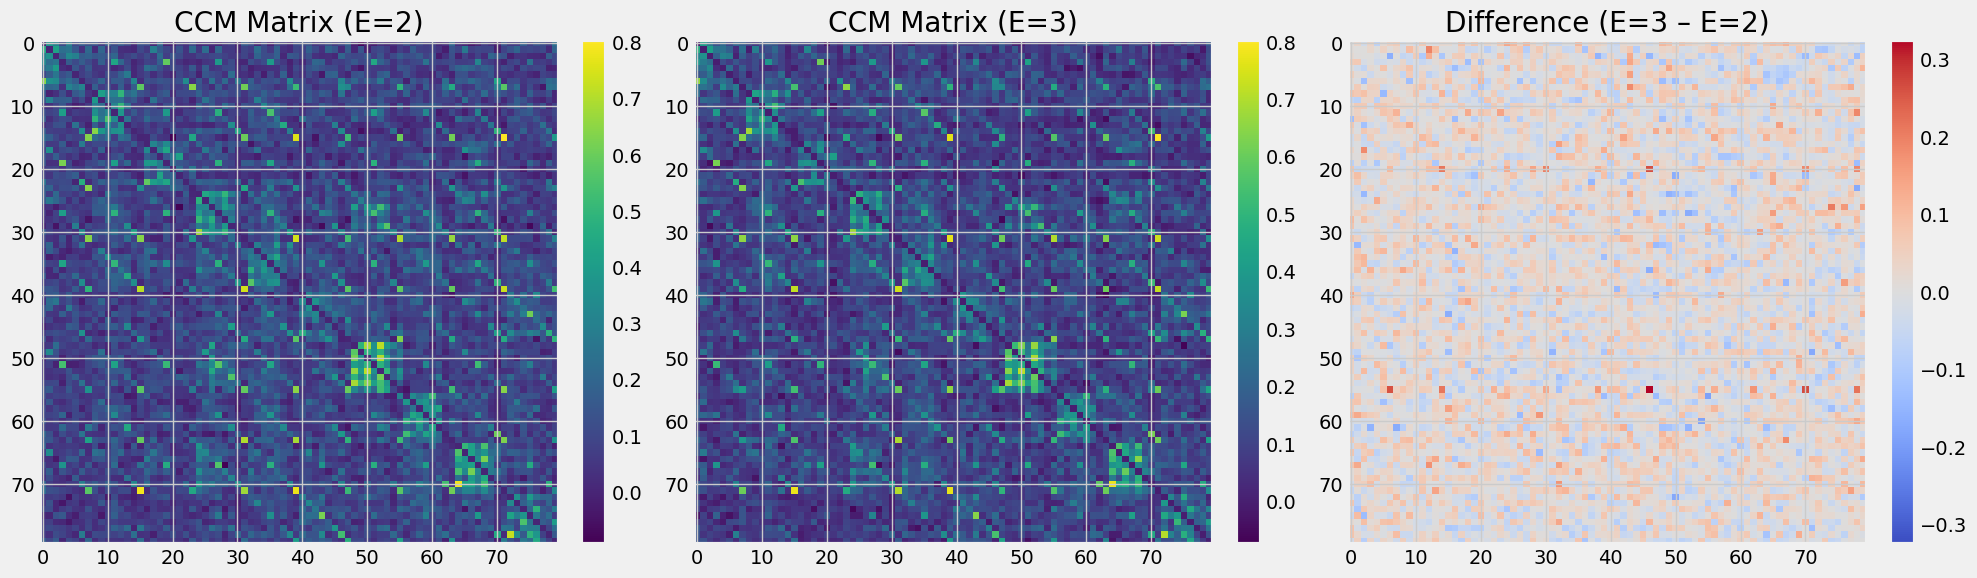

In [42]:
# appendix Robustness checks: We now report results obtained with surrogate and shuffled versions of the time series,



writefile=1
E=3
if writefile==1:
    corrM_E3,lag_matrix_E3=computeCCM_matrix_test(dfreturn_ran, max_lag,E)
    # Save the TE and Lag matrices to CSV files
    corrM_E3.to_csv('data/CCM_matrix_E3.csv', index=True)
    lag_matrix_E3.to_csv('data/CCMlag_matrixE3.csv', index=True)
else:
    corrM_E3 = pd.read_csv('data/CCM_matrix_E3.csv', index_col=0)
    lag_matrix_E3 = pd.read_csv('data/CCMlag_matrixE3.csv', index_col=0)


corrM_E2 = pd.read_csv("data/CCM_matrix.csv", index_col=0)
corrM_E3 = pd.read_csv("data/CCM_matrix_3.csv", index_col=0)

corrM_E2 = corrM_E2.loc[corrM_E3.index, corrM_E3.columns]

from numpy.linalg import norm

# Flatten
v2 = corrM_E2.values.flatten()
v3 = corrM_E3.values.flatten()

# Pearson correlation
corr = np.corrcoef(v2, v3)[0,1]

# Norm difference
frob_diff = norm(v2 - v3) / norm(v2)

print("Pearson correlation:", corr)
print("Relative Frobenius difference:", frob_diff)
# Difference matrix
diff_matrix = corrM_E3 - corrM_E2

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# E=2
im1 = axes[0].imshow(corrM_E2, cmap="viridis", aspect="auto")
axes[0].set_title("CCM Matrix (E=2)")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# E=3
im2 = axes[1].imshow(corrM_E3, cmap="viridis", aspect="auto")
axes[1].set_title("CCM Matrix (E=3)")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Difference (E3 - E2)
vmax = np.max(np.abs(diff_matrix.values))
im3 = axes[2].imshow(diff_matrix, cmap="coolwarm", aspect="auto", vmin=-vmax, vmax=vmax)
axes[2].set_title("Difference (E=3 – E=2)")
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
fig.savefig('fig/Embeding_comparisonE2-E3.png', dpi=300, bbox_inches='tight')

Pearson correlation: 0.022631472903570187
Relative Frobenius difference: 0.8410736122692003


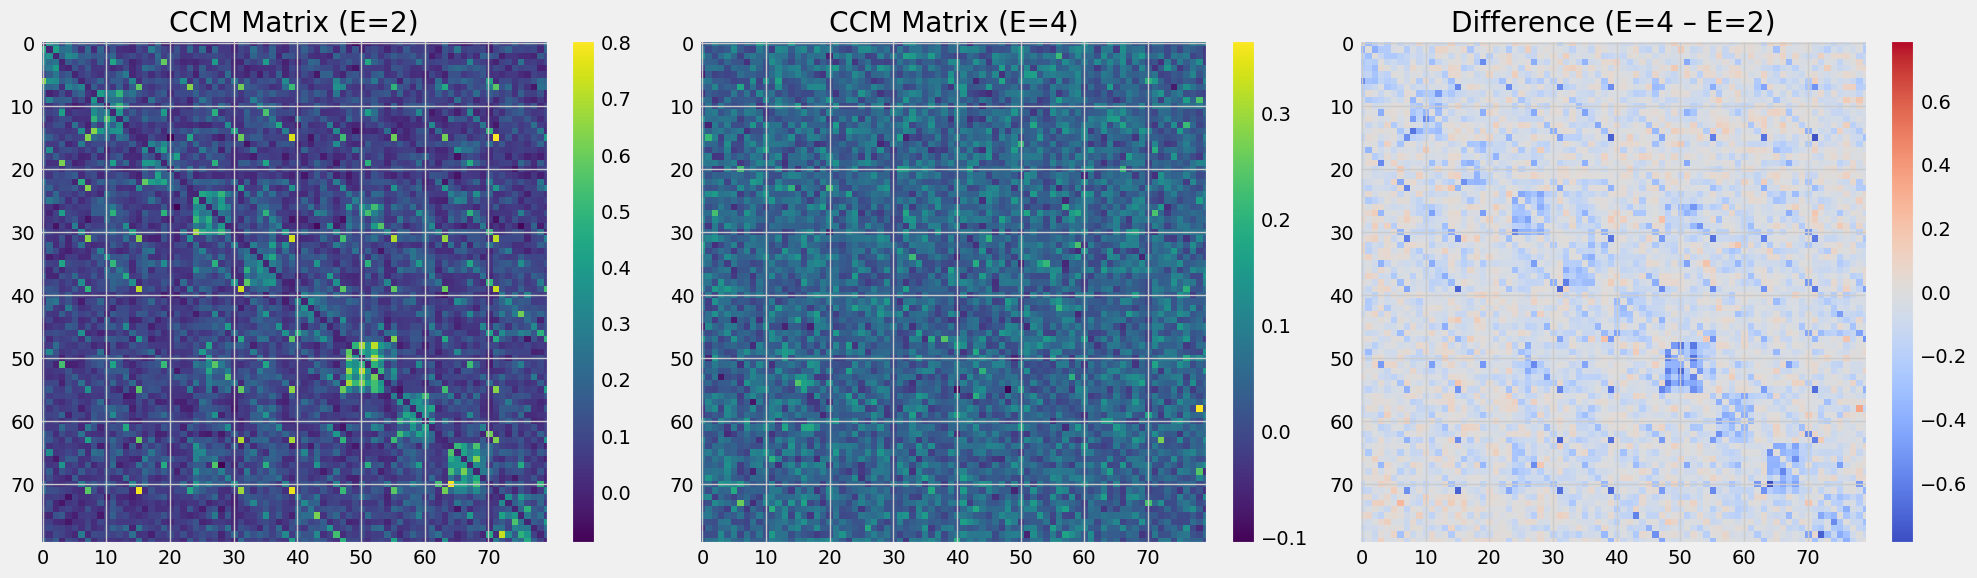

In [43]:
writefile=1
E=4
if writefile==1:
    corrM_E3,lag_matrix_E3=computeCCM_matrix_test(dfreturn_ran, max_lag,E)
    # Save the TE and Lag matrices to CSV files
    corrM_E3.to_csv('data/CCM_matrix_E4.csv', index=True)
    lag_matrix_E3.to_csv('data/CCMlag_matrixE4.csv', index=True)
else:
    corrM_E3 = pd.read_csv('data/CCM_matrix_E4.csv', index_col=0)
    lag_matrix_E3 = pd.read_csv('data/CCMlag_matrixE4.csv', index_col=0)





corrM_E2 = pd.read_csv("data/CCM_matrix.csv", index_col=0)
corrM_E3 = pd.read_csv("data/CCM_matrix_E4.csv", index_col=0)

corrM_E2 = corrM_E2.loc[corrM_E3.index, corrM_E3.columns]

from numpy.linalg import norm

# Flatten
v2 = corrM_E2.values.flatten()
v3 = corrM_E3.values.flatten()

# Pearson correlation
corr = np.corrcoef(v2, v3)[0,1]

# Norm difference
frob_diff = norm(v2 - v3) / norm(v2)

print("Pearson correlation:", corr)
print("Relative Frobenius difference:", frob_diff)


# Difference matrix
diff_matrix = corrM_E3 - corrM_E2

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# E=2
im1 = axes[0].imshow(corrM_E2, cmap="viridis", aspect="auto")
axes[0].set_title("CCM Matrix (E=2)")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# E=4
im2 = axes[1].imshow(corrM_E3, cmap="viridis", aspect="auto")
axes[1].set_title("CCM Matrix (E=4)")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Difference (E3 - E2)
vmax = np.max(np.abs(diff_matrix.values))
im3 = axes[2].imshow(diff_matrix, cmap="coolwarm", aspect="auto", vmin=-vmax, vmax=vmax)
axes[2].set_title("Difference (E=4 – E=2)")
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
fig.savefig('fig/Embeding_comparisonE2-E4.png', dpi=300, bbox_inches='tight')


In [30]:
# appendix Robustness checks: We now report results obtained with surrogate and shuffled versions of the time series,

dfreturn_ran= dfreturn.apply(np.random.permutation, axis=0)

# (Optional) Reset index to keep it clean
dfreturn_ran.index = dfreturn.index


writefile=1
E=2
if writefile==1:
    corrM_ran,lag_matrix_ran=computeCCM_matrix_test(dfreturn_ran, max_lag,E)
    # Save the TE and Lag matrices to CSV files
    corrM_ran.to_csv('data/CCM_matrix_random.csv', index=True)
    lag_matrix_ran.to_csv('data/CCMlag_matrixrandom.csv', index=True)
else:
    corrM_ran = pd.read_csv('data/CCM_matrix_random.csv', index_col=0)
    lag_matrix_ran = pd.read_csv('data/CCMlag_matrixrandom.csv', index_col=0)




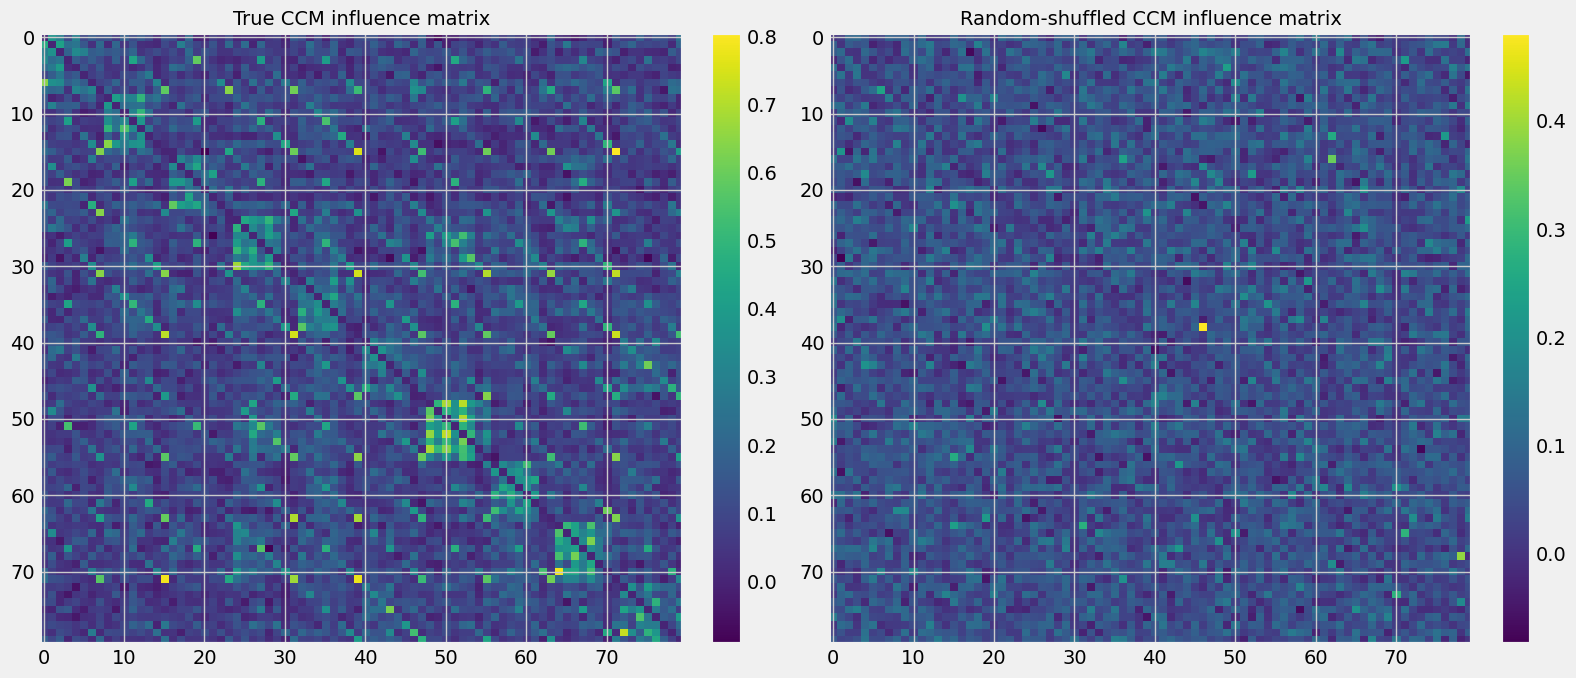

Mean (true CCM): 0.12054593749999999
Mean (random CCM): 0.05472078125000001
Std (true CCM): 0.11062485204395121
Std (random CCM): 0.04674422764512906
KS test statistic: 0.31984375
KS p-value: 8.415764943942262e-290


In [38]:
# Load the original and random CCM matrices
corrM = pd.read_csv("data/CCM_matrix.csv", index_col=0)        # true
corrM_ran = pd.read_csv("data/CCM_matrix_random.csv", index_col=0)  # shuffled

# Align indices to be safe
corrM = corrM.loc[corrM_ran.index, corrM_ran.columns]

# ---- 1. Visualization ----
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Original CCM
im1 = axes[0].imshow(corrM, cmap="viridis", aspect="auto")
axes[0].set_title("True CCM influence matrix", fontsize=14)
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Random CCM
im2 = axes[1].imshow(corrM_ran, cmap="viridis", aspect="auto")
axes[1].set_title("Random-shuffled CCM influence matrix", fontsize=14)
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# ---- 2. Quantitative comparison ----
# Flatten values (exclude diagonal if self-loops are zero)
v_true = corrM.values.flatten()
v_ran = corrM_ran.values.flatten()

# Mean and variance
mean_true, mean_ran = np.mean(v_true), np.mean(v_ran)
std_true, std_ran = np.std(v_true), np.std(v_ran)

# Kolmogorov-Smirnov test: are they drawn from the same distribution?
from scipy.stats import ks_2samp
ks_stat, ks_pval = ks_2samp(v_true, v_ran)

print("Mean (true CCM):", mean_true)
print("Mean (random CCM):", mean_ran)
print("Std (true CCM):", std_true)
print("Std (random CCM):", std_ran)
print("KS test statistic:", ks_stat)
print("KS p-value:", ks_pval)

fig.savefig('fig/RanvsCCMmatrix_comparison.png', dpi=300, bbox_inches='tight')